# Input

In [1]:
# Parameters
proposal_id = "9YJQWolIoQ2coRMfYc5U"
system_path = (
    "/Users/huiwenchong/Documents/GitHub/kaya-services/services/ad_research/.."
)
google_cred_path = "/Users/huiwenchong/Documents/GitHub/kaya-services/services/ad_research/../../.local/kaya-apps-00-prod.json"


# Library

In [2]:
import os
import sys

print(system_path)
sys.path.append(system_path) # go to parent dir

/Users/huiwenchong/Documents/GitHub/kaya-services/services/ad_research/..


In [3]:
os.environ['GCP_PROJECT_NAME'] = 'kaya-apps-00'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = google_cred_path
os.environ['ENV'] = 'LOCAL_PROD'

from secret_manager.set_env_variables_from_secrets import set_env_variables_from_secrets

In [4]:
set_env_variables_from_secrets(secret_ids=["ALGOLIA_API_KEY", "SEMRUSH_API_KEY", "OPENAI_API_KEY"])

Set environment variable for ALGOLIA_API_KEY
Set environment variable for SEMRUSH_API_KEY
Set environment variable for OPENAI_API_KEY


In [5]:
import pandas as pd
import numpy as np
from firestore import FirestoreClient
from algoliasearch.search_client import SearchClient
from dateutil.relativedelta import relativedelta
import datetime as dt
from fuzzywuzzy import fuzz

import uuid

import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean 
from storage.upload_blob import upload_blob

from ad_research.notebook.analyse_company_utils import (
    count_max_active_ads_per_month,
    count_active_ads_per_month, 
    months_between_dates,
    get_index_with_highest_value,
    get_index_with_lowest_value,
    save_and_upload_fig,
)
from utils.dataframe import round_dataframe
from utils.list import join_list_of_str_with_and
from utils.string_ops import int_to_accounting_format


/Users/huiwenchong/Documents/GitHub/kaya-services/venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
_FS = FirestoreClient()

Initialising Firestore App:  {'kaya-apps-00'}


# Initialize data sources

## Firestore

In [7]:
p = _FS.get_single_document("proposal", proposal_id)
p

{'created_at': '2024-05-14T10:55:15Z',
 'marketing_ideas': "**Awareness**\n\nPain point:\nUsers are concerned about the environmental impact of single-use plastics.\n\nExample ad copies:\n- Join HydrosLife's Mission to Save the Planet – Ditch Single-Use Plastics Today!\n- Every Sip Counts – Switch to HydrosLife and Make a Difference!\n- HydrosLife – Your Eco-Friendly Solution to a Healthier Planet!\n\nDesire:\nUsers want to ensure they're drinking clean, filtered water quickly and efficiently.\n\nExample ad copies:\n- Experience Unmatched Purity with HydrosLife's Fast-Filter Tech!\n- Speed & Purity in Every Pour – Discover HydrosLife Today!\n- Clear, Clean, Quick – HydrosLife's Filters Are Changing the Game!\n\n\n\n**Consideration**\n\nPain point:\nUsers are looking for high-quality, reliable water filtration systems that match their lifestyle.\n\nExample ad copies:\n- Pure Water, Pure Life – Trust in HydrosLife's Superior Filtration!\n- Taste the Quality, Feel the Difference with Hydr

In [8]:
proposal_company_id = p['proposal_company_id']
print("proposal_company_id: ", proposal_company_id)

proposal_company_id:  iCQESooXqodU9IjJiUnL


In [9]:
comp_company_id_map = {
    v: k for k, v in p['competitors'].items()
}

proposal_company_id_mapping = {**comp_company_id_map, p['proposal_company_id']: p['domain']}
proposal_company_id_mapping

{'c6Yl5sqDNnW332qJSwXQ': 'drinkcirkul.com/',
 'd13SWUzDlOQaeFVnUNsC': 'brita.com',
 '19nGuLBeKDT2Np1d9QKk': 'drinksoma.com',
 'iCQESooXqodU9IjJiUnL': 'hydroslife.com'}

In [10]:
lead_domain = p['domain']
lead_company = lead_domain.split('.')[0]

print("lead_domain: ", lead_domain)
print("lead_company: ", lead_company)

lead_domain:  hydroslife.com
lead_company:  hydroslife


## Algolia

In [11]:
def get_algolia_data_in_df(proposal_id):
    alg_client = SearchClient.create("9UOFA9X1DB", os.environ['ALGOLIA_API_KEY'])
    ad_research_sample_index = alg_client.init_index("ad_research_sample")

    all_ads_out = ad_research_sample_index.browse_objects(
        {"filters": f"proposal_id:{proposal_id}"}
    )

    all_ads_algolia = [a for a in all_ads_out]

    if len(all_ads_algolia) == 0:
        raise Exception("No ads found in Algolia")
    
    all_ads_df = pd.DataFrame(all_ads_algolia)

    print(all_ads_df.shape)

    if all_ads_df.shape[0] == 0:
        raise (f"Terminating. No ads found for {proposal_id}..")

    return all_ads_df

In [12]:
all_ads_df = get_algolia_data_in_df(proposal_id)
all_ads_df.head().T

(326, 37)


0  \
platform                                                        meta_ads   
format                                                             video   
landing_page_url                  https://drinkcirkul.com/pages/brittney   
landing_page_full_url             https://drinkcirkul.com/pages/brittney   
metrics                                                               []   
ctas                                                        [Learn more]   
ad_id                                                      6597521047253   
headline                                                            None   
body                   After school chaos is a real thing. The girls ...   
tags                                                                  []   
first_seen                                                    2024-05-08   
last_seen                                                     2024-05-14   
num_variants                                                         1.0   
channels                                [facebook, instagram, messenger]   
link_description                                         drinkcirkul.com   
audience_targeting                                                    []   
uuid                                16c46f1d-d21d-4d8f-844a-acd0889a42ea   
proposal_company_id                                 c6Yl5sqDNnW332qJSwXQ   
proposal_id                                         9YJQWolIoQ2coRMfYc5U   
video_url              https://video-mia3-1.xx.fbcdn.net/v/t42.1790-2...   
original_image_url     https://scontent-mia3-2.xx.fbcdn.net/v/t39.354...   
business_name                                                Drinkcirkul   
domain                                                  drinkcirkul.com/   
industry                                                                   
sub_industry                                                               
description            DrinkCirkul is a transformative beverage compa...   
is_featured                                                        False   
objectID                                          meta_ads_6597521047253   
is_dco                                                               NaN   
caption                                                              NaN   
cta_text                                                             NaN   
slides                                                               NaN   
num_tags                                                             NaN   
image_url                                                            NaN   
advertiser_social_id                                                 NaN   
advertiser_name                                                      NaN   
days_active                                                          NaN   

                                                                       1  \
platform                                                        meta_ads   
format                                                             video   
landing_page_url                   https://drinkcirkul.com/pages/rebecca   
landing_page_full_url              https://drinkcirkul.com/pages/rebecca   
metrics                                                               []   
ctas                                                        [Learn more]   
ad_id                                                      6597520476653   
headline                                                            None   
body                   🩷 ✈️ 💧 🌴 Traveling with a big family we have t...   
tags                                                                  []   
first_seen                                                    2024-05-08   
last_seen                                                     2024-05-14   
num_variants                                                         1.0   
channels                                [facebook, instagram, messenger]   
link_description                          

# Create object class

In [13]:
# create class
class Company:       
    def __init__(self):    
        self.has_probable_platform = 0
        self.probable_platforms = []
        
        self.platform_active_count = 0 

        self.has_top_ad_platform = 0
        
        self.has_platform_activity_changes = 0
        self.platform_activity_changes = [] # 1 if activated, -1 if deactivated
        self.platform_active_months = []
        self.platform_inactive_months = []
        self.overall_inactive_months = 0

        self.platform_ad_count = []
        self.platform_ad_count_pct_change = []
        self.platform_ad_count_pct_dist = []

        self.overall_ad_count = 0
        self.is_overall_highest_ad_count = 0

        self.has_format_activity_changes = 0
        self.format_activity_changes = [] # 1 if activated, -1 if deactivated
        self.platform_format_activity_changes = {}
        self.platform_format_ad_count = {}
        self.platform_format_ad_count_pct_change = {}

        self.avg_mth_sem_budget = 0
        self.median_mth_sem_budget = 0
        self.total_annual_sem_budget = 0

        self.is_overall_lowest_ad_budget = 0
        self.is_overall_highest_ad_budget = 0

        self.is_significant_ad_count_change = 0
        self.is_significant_budget_change = 0        

        self.mth_sem_budget = 0
        self.mth_sem_budget_pct_change = 0

In [14]:
# write to class object
def write_to_single_obj_company(obj_feature_name, comp, comp_value):
    obj = objects.get(comp)
    setattr(obj, obj_feature_name, comp_value)

    # read and check attribute
    for comp, obj in objects.items():
        obj_feature = getattr(obj, obj_feature_name)
        print(f"{comp} \n - {obj_feature_name}: {obj_feature}")


def write_to_obj_company(df, obj_feature_name):
    last_month = df.columns[-1] 

    for comp, row in df.iterrows():
        last_month_val = row[last_month]

        if last_month_val != 0:
            obj = objects.get(comp)
            setattr(obj, obj_feature_name, last_month_val)
        else:
            pass

    # read and check attribute
    for comp, obj in objects.items():
        obj_feature = getattr(obj, obj_feature_name)
        print(f"{comp} \n - {obj_feature_name}: {obj_feature}")


def write_to_obj_company_platform(df, obj_feature_name):
    last_month = df.columns[-1] 

    comp_dict = {}
    for idx, row in df.iterrows():
        comp = idx[0]
        platform = idx[1]

        last_month_val = row[last_month]
        pltf_tup = (platform, last_month_val)

        if last_month_val != 0:
            pltf_tup = (platform, last_month_val)

            if comp not in comp_dict:
                pltf_list = []
                pltf_list.append(pltf_tup)
                comp_dict[comp] = pltf_list
            else:
                pltf_list = comp_dict.get(comp, [])
                pltf_list.append(pltf_tup)
                comp_dict[comp] = pltf_list
        else:
            pass

    # set attribute
    for comp, pltf_list in comp_dict.items():
        obj = objects.get(comp)
        setattr(obj, obj_feature_name, pltf_list)

    print("comp_dict: ", comp_dict)

    # read and check attribute
    for comp, obj in objects.items():
        obj_feature = getattr(obj, obj_feature_name)
        print(f"{comp} \n - {obj_feature_name}: {obj_feature}")


def write_to_obj_company_platform_format(df, obj_feature_name):
    last_month = df.columns[-1] 

    comp_dict = {}
    for idx, row in df.iterrows():
        comp = idx[0]
        platform = idx[1]
        format = idx[2]

        last_month_val = row[last_month]
        format_tup = (format, last_month_val)

        if last_month_val != 0:
            format_tup = (format, last_month_val)

            if comp not in comp_dict:
                format_list = []
                format_list.append(format_tup)
                comp_dict[comp] = {platform: format_list}
                
            else:
                platform_dict = comp_dict.get(comp, {})
                if platform in platform_dict:
                    format_list = platform_dict.get(platform, [])
                    format_list.append(format_tup)

                else:
                    format_list = []
                    format_list.append(format_tup)
                    platform_dict[platform] = format_list

        else:
            pass

    # set attribute
    for comp, pltf_format_dict in comp_dict.items():
        obj = objects.get(comp)
        setattr(obj, obj_feature_name, pltf_format_dict)

    print("comp_dict: ", comp_dict)

    # read and check attribute
    for comp, obj in objects.items():
        obj_feature = getattr(obj, obj_feature_name)
        print(f"{comp} \n - {obj_feature_name}: {obj_feature}")


def read_object_data(comp, obj):
  output_string = f"company: {comp}\n"

  for attr, value in obj.__dict__.items():
      output_string += f"{attr}: {value}\n"

  return output_string

In [15]:
# instantiate classes
company_list = all_ads_df['business_name'].unique().tolist()
company_list.sort()

objects = {}
for comp in company_list:
    objects[comp] = Company()

print("objects:", objects)

objects: {'Brita': <__main__.Company object at 0x10778f4f0>, 'Drinkcirkul': <__main__.Company object at 0x102e6dc10>, 'Drinksoma': <__main__.Company object at 0x102e6d9a0>, 'Hydroslife': <__main__.Company object at 0x102e6da00>}


# Define time variables

In [16]:
as_of_date = dt.date.today()
as_of_date_str = as_of_date.strftime('%Y-%m-%d')
as_of_month = as_of_date_str[:7]

as_of_month_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d')
one_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=1)
three_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=3)
one_year_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(years=1)

one_month_ago = one_month_ago_dt.strftime('%b-%Y')
one_month_ago_yyyymm = one_month_ago_dt.strftime('%Y%m')

print("as_of_date: ", as_of_date)
print("as_of_month: ", as_of_month)
print("as_of_month_dt: ", as_of_month_dt)
print("one_month_ago_dt: ", one_month_ago_dt)
print("three_month_ago_dt: ", three_month_ago_dt)
print("one_year_ago_dt: ", one_year_ago_dt)
print("one_month_ago: ", one_month_ago)
print("one_month_ago_yyyymm: ", one_month_ago_yyyymm)

as_of_date:  2024-06-18
as_of_month:  2024-06
as_of_month_dt:  2024-06-01 00:00:00
one_month_ago_dt:  2024-05-01 00:00:00
three_month_ago_dt:  2024-03-01 00:00:00
one_year_ago_dt:  2023-06-01 00:00:00
one_month_ago:  May-2024
one_month_ago_yyyymm:  202405


# Prepare base table

In [17]:
def process_missing_first_and_last_seen(all_ads_df, start_date, end_date):
    # assign default probability of 1
    all_ads_df['probability'] = 1

    # if first_seen or last seen is null, assign probability of 0.5
    filter_null_first_seen = all_ads_df['first_seen'].isnull()
    all_ads_df.loc[filter_null_first_seen, 'first_seen'] = start_date
    all_ads_df.loc[filter_null_first_seen, 'probability'] = 0.5

    filter_null_last_seen = all_ads_df['last_seen'].isnull()
    all_ads_df.loc[filter_null_last_seen, 'last_seen'] = end_date
    all_ads_df.loc[filter_null_last_seen, 'probability'] = 0.5

    # derive month and datetime columns
    for sm in ['first_seen', 'last_seen']:
        all_ads_df[f'{sm}_month'] = all_ads_df[sm].str[:7]
        all_ads_df[f'{sm}_dt'] = pd.to_datetime(all_ads_df[sm])

    return all_ads_df

In [18]:
# define start and end_date
today = dt.date.today()
a_year_ago = today - relativedelta(years=1)

print("today: ", today)
print("a_year_ago: ", a_year_ago)

# process null first_seen and last_seen
all_ads_df = process_missing_first_and_last_seen(
    all_ads_df, 
    start_date=a_year_ago, 
    end_date=today,
)

# process domain
all_ads_df['domain'] = all_ads_df['proposal_company_id'].map(proposal_company_id_mapping)

# process platform
all_ads_df['platform_shortname'] = all_ads_df['platform'].map(
    {
        'tiktok_ads': 'TT',
        'meta_ads': 'M',
        'linkedin_ads': 'LI',
        'google_ads': "G", 
        'bing_ads': "B"
    }
)

print("unique platforms: ", all_ads_df['platform'].unique())

all_ads_df['company_platform'] = all_ads_df['business_name'] + " • " + all_ads_df['platform_shortname']

today:  2024-06-18
a_year_ago:  2023-06-18
unique platforms:  ['meta_ads' 'google_ads' 'bing_ads']


/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/3222183452.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_ads_df.loc[filter_null_first_seen, 'probability'] = 0.5


In [19]:
def summarise_by_company_platform_max_active_ads(all_ads_df):
    summarised_dfs = []

    for dm in all_ads_df['company_platform'].unique():
        try:
            summarised_dfs += count_max_active_ads_per_month(all_ads_df[all_ads_df['company_platform']==dm], company_platform=dm)
        except:
            print("Error: ", dm)
            pass
        
    summarised_df = pd.DataFrame(summarised_dfs)

    # flag as is_active if ad count > 0
    summarised_df.loc[summarised_df['count'] > 0, 'is_active'] = 1

    return summarised_df

def summarise_by_company_platform_active_ads(all_ads_df):
    summarised_dfs = []

    for dm in all_ads_df['company_platform'].unique():
        try:
            summarised_dfs += count_active_ads_per_month(all_ads_df[all_ads_df['company_platform']==dm], company_platform=dm)
        except:
            print("Error: ", dm)
            pass
        
    summarised_df = pd.DataFrame(summarised_dfs)

    # flag as is_active if ad count > 0
    summarised_df.loc[summarised_df['count'] > 0, 'is_active'] = 1

    return summarised_df

def create_table_for_overall_heatmap(summarised_df, month_df):
    pivot_df = pd.pivot_table(
        summarised_df,
        index='month',
        columns='company_platform',
        aggfunc='max', 
        values='probability'
    ).reset_index()

    plot_df = pd.merge(
        month_df,
        pivot_df,
        how='left',
        on='month'
    ).set_index('month').fillna(0)

    plot_df.index = plot_df.index.str[:7]
    plot_df = plot_df.T

    # update col names so the plot is not so crowded
    ori_cols = plot_df.columns
    plot_df.columns = [c if idx%3 == 0 else '' for idx, c in enumerate(ori_cols)]


    # do the same for index / row
    ori_index = plot_df.index
    new_index = []
    last_biz = ''
    for idx, biz_platform in enumerate(ori_index):
        cur_biz = biz_platform.split(" • ")[0]
        cur_platform = biz_platform.split(" • ")[1]
        
        if cur_biz == last_biz:
            new_index.append(cur_platform)
        else:
            new_index.append(f"➤ {cur_biz}  •  {cur_platform}")
        
        last_biz = cur_biz

    plot_df.index = new_index

    return plot_df


def plot_overall_heatmap(plot_df, _IMAGE_BUCKET):
    heatmap_filename = f'comp_ad_monthly_breakdown_heatmap_{uuid.uuid4()}.png'
    heatmap_filepath = f'/tmp/{heatmap_filename}'

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize = (10, 10))

    ax = sns.heatmap(
        plot_df, 
        cmap=['#F4F1F4', '#E9DFFB', '#9283AC'], 
        linewidths=0.005,
        cbar=False,
        square=True
    )

    ax.tick_params(axis='x', rotation=0, size=8)
    # ax.tick_params(axis='y', rotation=0, size=12)
    # ax.set_ylabel("", fontsize=60)


    plt.show()
    fig = ax.get_figure()
    fig.savefig(heatmap_filepath, bbox_inches="tight")


    heatmap_storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=heatmap_filepath, 
        destination_blob_name=f"proposal/{proposal_id}/overview/{heatmap_filename}", 
        is_public=True
    )

    print(f"""
    Legend
    ------
    · Dark: Running ads
    · Light: Might be running ads
    · Grey: Not running ads
    """
    )

    return heatmap_storage_url


def create_base_table_by_ad_count(summarised_df, month_df):
    # create base table
    month_df['key'] = 0
    unq_pltf_df = pd.DataFrame(summarised_df['company_platform'].drop_duplicates())
    unq_pltf_df['key'] = 0

    month_pltf_df = month_df.merge(unq_pltf_df, on='key', how='outer')
    month_pltf_df['month'] = pd.to_datetime(month_pltf_df['month'], format='%Y-%m')
    summarised_df['month'] = pd.to_datetime(summarised_df['month'], format='%Y-%m')

    pltf_df = pd.merge(
        month_pltf_df,
        summarised_df,
        how='left',
        on=['month', 'company_platform']
    ).fillna(0).reset_index(drop=True)

    pltf_df = pltf_df.drop(columns='key')

    # filter for L12M data
    pltf_df['month'] = pd.to_datetime(pltf_df['month'], format='%Y-%m')
    
    _one_year_ago = one_year_ago_dt.strftime('%Y-%m')
    _one_month_ago = one_month_ago_dt.strftime('%Y-%m')
    pltf_df = pltf_df[(pltf_df['month'] >= _one_year_ago) & (pltf_df['month'] <= _one_month_ago)]
    
    # today = pd.to_datetime('today')
    # last_year = today - pd.DateOffset(months=12)
    # pltf_df = pltf_df[(pltf_df['month'] > last_year) & (pltf_df['month'] <= today)]
    
    # split platform
    # define a dictionary for platform mapping
    platform_map = {
        'B': 'Bing', 
        'G': 'Google', 
        'LI': 'LinkedIn',
        'M': 'Meta',
        'TT': 'TikTok',
    }

    def split_platform(text):
        parts = text.split('•')
        company = parts[0].strip()
        _platform = parts[1].strip()
        platform = platform_map.get(_platform, _platform)
        return company, platform

    pltf_df[['company', 'platform']] = pltf_df['company_platform'].apply(split_platform).tolist()
    pltf_df = pltf_df.drop(columns='company_platform')

    return pltf_df

In [20]:
as_of_date = dt.date.today()
as_of_date_str = as_of_date.strftime('%Y-%m-%d')
as_of_month = as_of_date_str[:7]

as_of_month_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d')
one_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=1)
three_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=3)
one_year_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(years=1)

print("as_of_date: ", as_of_date)
print("as_of_month: ", as_of_month)
print("as_of_month_dt: ", as_of_month_dt)
print("one_month_ago_dt: ", one_month_ago_dt)
print("three_month_ago_dt: ", three_month_ago_dt)
print("one_year_ago_dt: ", one_year_ago_dt)

as_of_date:  2024-06-18
as_of_month:  2024-06
as_of_month_dt:  2024-06-01 00:00:00
one_month_ago_dt:  2024-05-01 00:00:00
three_month_ago_dt:  2024-03-01 00:00:00
one_year_ago_dt:  2023-06-01 00:00:00


In [21]:
# get number of active ads by company platform
max_summarised_df = summarise_by_company_platform_max_active_ads(all_ads_df)

# filter dfs for desired date range
start_date = one_year_ago_dt
end_date = one_month_ago_dt

month_df = months_between_dates(start_date, end_date)

_one_year_ago = start_date.strftime('%Y-%m')
_one_month_ago = end_date.strftime('%Y-%m')
max_summarised_df = max_summarised_df[(max_summarised_df['month'] >= _one_year_ago) & (max_summarised_df['month'] <= _one_month_ago)]

# check
for df in [max_summarised_df, month_df]:
    print("min_month: ", df['month'].min(), "max_month: ", df['month'].max())
    display(df.head(2))

min_month:  2023-06 max_month:  2024-05


month  count  probability company_platform  is_active
0  2024-01      9          1.0  Drinkcirkul • M        1.0
1  2024-02      9          1.0  Drinkcirkul • M        1.0

min_month:  2023-06 max_month:  2024-05


month
0  2023-06
1  2023-07

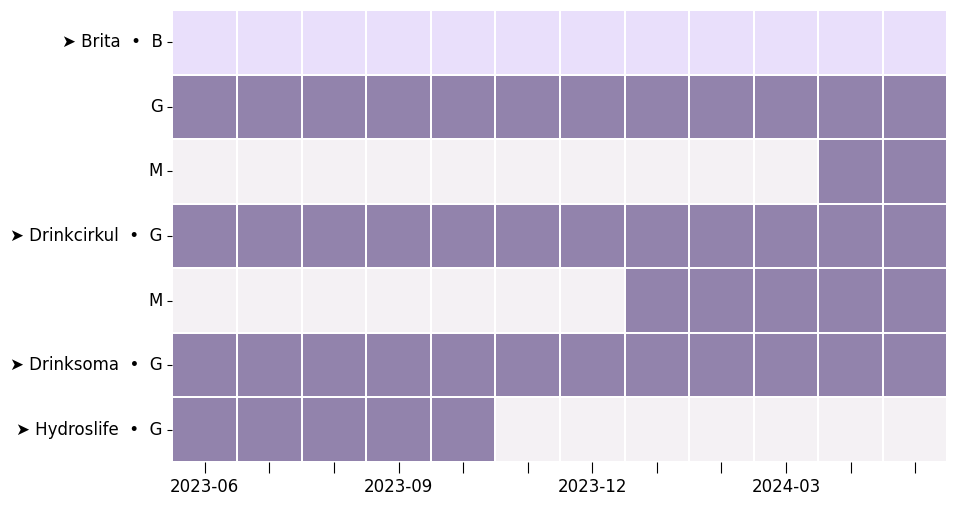

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/comp_ad_monthly_breakdown_heatmap_c575d6ae-6466-4aca-8bd4-1b20be4d0ecf.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview/comp_ad_monthly_breakdown_heatmap_c575d6ae-6466-4aca-8bd4-1b20be4d0ecf.png.

    Legend
    ------
    · Dark: Running ads
    · Light: Might be running ads
    · Grey: Not running ads
    


In [22]:
# plot overall competitive landscape heatmap
_IMAGE_BUCKET = "kaya-apps-00-public"

plot_df = create_table_for_overall_heatmap(max_summarised_df, month_df)
heatmap_storage_url = plot_overall_heatmap(plot_df, _IMAGE_BUCKET)

In [23]:
# get number of active ads by company platform
summarised_df = summarise_by_company_platform_active_ads(all_ads_df)

# filter dfs for desired date range
summarised_df = summarised_df[(summarised_df['month'] >= _one_year_ago) & (summarised_df['month'] <= _one_month_ago)]

# check
for df in [summarised_df, month_df]:
    print("min_month: ", df['month'].min(), "max_month: ", df['month'].max())
    display(df.head(2))

min_month:  2023-06 max_month:  2024-05


month  count  probability company_platform  is_active
0  2024-01      9          1.0  Drinkcirkul • M        1.0
1  2024-02      9          1.0  Drinkcirkul • M        1.0

min_month:  2023-06 max_month:  2024-05


month
0  2023-06
1  2023-07

In [24]:
# create base table
pltf_base_df = create_base_table_by_ad_count(summarised_df, month_df)

pltf_base_df.head()

month  count  probability  is_active      company platform
0 2023-06-01    0.0          0.0        0.0  Drinkcirkul     Meta
1 2023-06-01    0.0          0.0        0.0        Brita     Meta
2 2023-06-01    3.0          1.0        1.0  Drinkcirkul   Google
3 2023-06-01  116.0          1.0        1.0        Brita   Google
4 2023-06-01    3.0          1.0        1.0   Hydroslife   Google

In [25]:
pltf_base_df.month.max()

Timestamp('2024-05-01 00:00:00')

# --- Probable Ads ---

In [26]:
# filter for latest month data only
pltf_proba_df = pltf_base_df.copy(deep=True)
latest_month = pltf_proba_df['month'].max()
pltf_proba_df = pltf_proba_df[pltf_proba_df['month'] == latest_month]

# dedup for largest probability for each company-platform pair
pltf_proba_df = pltf_proba_df.sort_values(by=['company', 'platform'], ascending=[True, False])
pltf_proba_df = pltf_proba_df.drop_duplicates(subset=['company', 'platform'], keep="first")
pltf_proba_df

# companies_w_probable_ads = pltf_base_df.loc[pltf_base_df['probability'] == 0.5]['company'].unique().tolist()
# companies_w_nonprobable_ads = pltf_base_df.loc[pltf_base_df['probability'] == 1]['company'].unique().tolist()
# companies_w_probable_ads
# # print("companies_w_probable_ads_only: ", companies_w_probable_ads_only)

month  count  probability  is_active      company platform
78 2024-05-01   18.0          1.0        1.0        Brita     Meta
80 2024-05-01   35.0          1.0        1.0        Brita   Google
83 2024-05-01   39.0          0.5        1.0        Brita     Bing
77 2024-05-01   75.0          1.0        1.0  Drinkcirkul     Meta
79 2024-05-01    2.0          1.0        1.0  Drinkcirkul   Google
82 2024-05-01   19.0          1.0        1.0    Drinksoma   Google
81 2024-05-01    0.0          0.0        0.0   Hydroslife   Google

In [27]:
pltf_proba_agg_df = pltf_proba_df.groupby(['company', 'probability'])['platform'].apply(list).reset_index(name='platform_list')
pltf_proba_agg_df

company  probability   platform_list
0        Brita          0.5          [Bing]
1        Brita          1.0  [Meta, Google]
2  Drinkcirkul          1.0  [Meta, Google]
3    Drinksoma          1.0        [Google]
4   Hydroslife          0.0        [Google]

In [28]:
pltf_proba_ads_df = pltf_proba_agg_df[pltf_proba_agg_df['probability'] == 0.5]
pltf_proba_ads_df

company  probability platform_list
0   Brita          0.5        [Bing]

In [29]:
# filter for probable ads only for analysis
# probability col can have values: 0, 0.5, 1

# write to object
pltf_proba_ads_df = pltf_proba_agg_df[pltf_proba_agg_df['probability'] == 0.5]

if len(pltf_proba_ads_df) > 0:

    companies = pltf_proba_ads_df['company'].unique().tolist()
    for comp in companies:
        write_to_single_obj_company("has_probable_platform", comp, 1)

        probable_platforms = pltf_proba_ads_df.loc[pltf_proba_ads_df['company'] == comp, 'platform_list'].iloc[0]
        write_to_single_obj_company("probable_platforms", comp, probable_platforms)

else:
    print("All companies are running on definite platforms")
    pass


Brita 
 - has_probable_platform: 1
Drinkcirkul 
 - has_probable_platform: 0
Drinksoma 
 - has_probable_platform: 0
Hydroslife 
 - has_probable_platform: 0
Brita 
 - probable_platforms: ['Bing']
Drinkcirkul 
 - probable_platforms: []
Drinksoma 
 - probable_platforms: []
Hydroslife 
 - probable_platforms: []


# --- Active Ads ---

In [30]:
# filter for confirmed active ads only for analysis
# probability col can have values: 0, 0.5, 1
pltf_df = pltf_base_df[pltf_base_df['probability'] == 1]

print("min_month: ", pltf_df['month'].min(), "max_month: ", pltf_df['month'].max())
pltf_df.head()

min_month:  2023-06-01 00:00:00 max_month:  2024-05-01 00:00:00


month  count  probability  is_active      company platform
2 2023-06-01    3.0          1.0        1.0  Drinkcirkul   Google
3 2023-06-01  116.0          1.0        1.0        Brita   Google
4 2023-06-01    3.0          1.0        1.0   Hydroslife   Google
5 2023-06-01   27.0          1.0        1.0    Drinksoma   Google
9 2023-07-01    8.0          1.0        1.0  Drinkcirkul   Google

# Analyse Company by Ad Distribution

## Ad channel activity

### Active

In [31]:
comp_pltf_activity_df = pltf_df.copy(deep=True)[['company', 'platform', 'month', 'is_active']]
comp_pltf_activity_df = comp_pltf_activity_df.sort_values(by=['company', 'platform', 'month']).reset_index(drop=True)

comp_pltf_activity_df['n_months_active'] = 0


# Define a function to calculate consecutive active months
def calc_consecutive_active(group):
    group['is_active_prev'] = group['is_active'].shift(1).fillna(0)  # Flag for previous month activity
    group['n_months_active'] = group['is_active'].cumsum()  # Cumulative sum of active months
    group.loc[group['is_active'] == 0, 'n_months_active'] = 0  # Reset counter if not active
    return group

# Apply the function by group (company & platform)
comp_pltf_active_df = comp_pltf_activity_df.groupby(['company', 'platform']).apply(calc_consecutive_active)
comp_pltf_active_df = comp_pltf_active_df.drop(columns={'company', 'platform'})

def check_active_status_change(is_active_prev, is_active):
    if (is_active_prev == 0) & (is_active == 1):
        return 1
    elif (is_active_prev == 1) & (is_active == 0):
        return -1
    else:
        return 0
    

comp_pltf_active_df['active_status_change'] = comp_pltf_active_df.apply(lambda x: check_active_status_change(x.is_active_prev, x.is_active), axis=1)

comp_pltf_active_df = comp_pltf_active_df.reset_index(drop=False)
comp_pltf_active_df = comp_pltf_active_df.drop(columns={'level_2'})

comp_pltf_active_df.head()

/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/1835256255.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_pltf_active_df = comp_pltf_activity_df.groupby(['company', 'platform']).apply(calc_consecutive_active)


company platform      month  is_active  n_months_active  is_active_prev  \
0   Brita   Google 2023-06-01        1.0              1.0             0.0   
1   Brita   Google 2023-07-01        1.0              2.0             1.0   
2   Brita   Google 2023-08-01        1.0              3.0             1.0   
3   Brita   Google 2023-09-01        1.0              4.0             1.0   
4   Brita   Google 2023-10-01        1.0              5.0             1.0   

   active_status_change  
0                     1  
1                     0  
2                     0  
3                     0  
4                     0

In [32]:
# how many platforms are active?

comp_pltf_total_active_df = pd.pivot_table(
    comp_pltf_active_df, 
    index=['company'], 
    columns='month', 
    values='is_active', 
    aggfunc='sum'
)
comp_pltf_total_active_df = comp_pltf_total_active_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_total_active_df)

    write_to_obj_company(comp_pltf_total_active_df, "platform_active_count")


month        2023-06-01  2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
company                                                                   
Brita                 1           1           1           1           1   
Drinkcirkul           1           1           1           1           1   
Drinksoma             1           1           1           1           1   
Hydroslife            1           1           1           1           1   

month        2023-11-01  2023-12-01  2024-01-01  2024-02-01  2024-03-01  \
company                                                                   
Brita                 1           1           1           1           1   
Drinkcirkul           1           1           2           2           2   
Drinksoma             1           1           1           1           1   
Hydroslife            0           0           0           0           0   

month        2024-04-01  2024-05-01  
company                              
Brita                 2           2  
Drinkcirkul           2           2  
Drinksoma             1           1  
Hydroslife            0           0

Brita 
 - platform_active_count: 2
Drinkcirkul 
 - platform_active_count: 2
Drinksoma 
 - platform_active_count: 1
Hydroslife 
 - platform_active_count: 0


In [33]:
# has there been channel active status change in previous month? 
# status change: active -> inactive (-1) / inactive -> active (1)

# eg. hydroslife needed to report changes in nov-23

comp_pltf_chg_active_df = pd.pivot_table(
    comp_pltf_active_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='active_status_change', 
    aggfunc='sum'
)
comp_pltf_chg_active_df = comp_pltf_chg_active_df.fillna(0).astype(int)

comp_pltf_chg_active_df

month                 2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
company     platform                                                   
Brita       Google             1           0           0           0   
            Meta               0           0           0           0   
Drinkcirkul Google             1           0           0           0   
            Meta               0           0           0           0   
Drinksoma   Google             1           0           0           0   
Hydroslife  Google             1           0           0           0   

month                 2023-10-01  2023-11-01  2023-12-01  2024-01-01  \
company     platform                                                   
Brita       Google             0           0           0           0   
            Meta               0           0           0           0   
Drinkcirkul Google             0           0           0           0   
            Meta               0           0           0           1   
Drinksoma   Google             0           0           0           0   
Hydroslife  Google             0           0           0           0   

month                 2024-02-01  2024-03-01  2024-04-01  2024-05-01  
company     platform                                                  
Brita       Google             0           0           0           0  
            Meta               0           0           1           0  
Drinkcirkul Google             0           0           0           0  
            Meta               0           0           0           0  
Drinksoma   Google             0           0           0           0  
Hydroslife  Google             0           0           0           0

In [34]:
# write to object
last_month = comp_pltf_total_active_df.columns[-1] 
last_month_str = last_month.strftime('%Y-%m')

last_comp_pltf_chg_active_df = comp_pltf_chg_active_df[comp_pltf_chg_active_df[last_month] != 0]

if len(last_comp_pltf_chg_active_df) > 0:
    write_to_obj_company_platform(last_comp_pltf_chg_active_df, "platform_activity_changes")

    companies = comp_pltf_chg_active_df.index.get_level_values('company').unique().tolist()
    for comp in companies:
        write_to_single_obj_company("has_platform_activity_changes", comp, 1)

else:
    print("No company has observed platform activity changes")
    pass


No company has observed platform activity changes


In [35]:
# how long have ads been running in channel?
# eg. hydroslife been running google ads for 5 months before stopping

comp_pltf_cum_active_df = pd.pivot_table(
    comp_pltf_active_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='n_months_active', 
    aggfunc='sum'
)
comp_pltf_cum_active_df = comp_pltf_cum_active_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_cum_active_df)

    write_to_obj_company_platform(comp_pltf_cum_active_df, "platform_active_months")

month                 2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
company     platform                                                   
Brita       Google             1           2           3           4   
            Meta               0           0           0           0   
Drinkcirkul Google             1           2           3           4   
            Meta               0           0           0           0   
Drinksoma   Google             1           2           3           4   
Hydroslife  Google             1           2           3           4   

month                 2023-10-01  2023-11-01  2023-12-01  2024-01-01  \
company     platform                                                   
Brita       Google             5           6           7           8   
            Meta               0           0           0           0   
Drinkcirkul Google             5           6           7           8   
            Meta               0           0           0           1   
Drinksoma   Google             5           6           7           8   
Hydroslife  Google             5           0           0           0   

month                 2024-02-01  2024-03-01  2024-04-01  2024-05-01  
company     platform                                                  
Brita       Google             9          10          11          12  
            Meta               0           0           1           2  
Drinkcirkul Google             9          10          11          12  
            Meta               2           3           4           5  
Drinksoma   Google             9          10          11          12  
Hydroslife  Google             0           0           0           0

comp_dict:  {'Brita': [('Google', 12), ('Meta', 2)], 'Drinkcirkul': [('Google', 12), ('Meta', 5)], 'Drinksoma': [('Google', 12)]}
Brita 
 - platform_active_months: [('Google', 12), ('Meta', 2)]
Drinkcirkul 
 - platform_active_months: [('Google', 12), ('Meta', 5)]
Drinksoma 
 - platform_active_months: [('Google', 12)]
Hydroslife 
 - platform_active_months: []


### Inactive

In [36]:
# how long have ads been inactive in channel?
# eg. hydroslife been on pause for 6 months for google

comp_pltf_cum_inactive_df = comp_pltf_activity_df.copy(deep=True)
 
comp_pltf_cum_inactive_df['n_months_inactive'] = 0
comp_pltf_cum_inactive_df['is_inactive'] = np.where(comp_pltf_cum_inactive_df['is_active'] == 1, 0, 1)

def calc_consecutive_inactive(group):
    group['is_active_prev'] = group['is_active'].shift(1).fillna(0)  # Flag for previous month activity
    group['n_months_inactive'] = group['is_inactive'].cumsum()  # Cumulative sum of active months
    group.loc[group['is_inactive'] == 0, 'n_months_inactive'] = 0  # Reset counter if not active
    return group

comp_pltf_cum_inactive_df = comp_pltf_cum_inactive_df.groupby(['company', 'platform']).apply(calc_consecutive_inactive)
comp_pltf_cum_inactive_df = comp_pltf_cum_inactive_df.drop(columns={'company', 'platform'})

comp_pltf_cum_inactive_df = pd.pivot_table(
    comp_pltf_cum_inactive_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='n_months_inactive', 
    aggfunc='sum'
)

# drop rows where it had been inactive for the past year
newnames = pd.to_datetime(comp_pltf_cum_inactive_df.columns, errors='coerce').strftime("%Y-%m")
comp_pltf_cum_inactive_df.columns = newnames.where(~newnames.isnull(), comp_pltf_cum_inactive_df.columns)

last_month = comp_pltf_cum_inactive_df.columns[-1] 
comp_pltf_cum_inactive_df = comp_pltf_cum_inactive_df[comp_pltf_cum_inactive_df[last_month] != 11]

comp_pltf_cum_inactive_df = comp_pltf_cum_inactive_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_cum_inactive_df)
    
    write_to_obj_company_platform(comp_pltf_cum_inactive_df, "platform_inactive_months")

/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/117258631.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_pltf_cum_inactive_df = comp_pltf_cum_inactive_df.groupby(['company', 'platform']).apply(calc_consecutive_inactive)


month                 2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  \
company     platform                                                         
Brita       Google          0        0        0        0        0        0   
            Meta            0        0        0        0        0        0   
Drinkcirkul Google          0        0        0        0        0        0   
            Meta            0        0        0        0        0        0   
Drinksoma   Google          0        0        0        0        0        0   
Hydroslife  Google          0        0        0        0        0        0   

month                 2023-12  2024-01  2024-02  2024-03  2024-04  2024-05  
company     platform                                                        
Brita       Google          0        0        0        0        0        0  
            Meta            0        0        0        0        0        0  
Drinkcirkul Google          0        0        0        0        0        0  
            Meta            0        0        0        0        0        0  
Drinksoma   Google          0        0        0        0        0        0  
Hydroslife  Google          0        0        0        0        0        0

comp_dict:  {}
Brita 
 - platform_inactive_months: []
Drinkcirkul 
 - platform_inactive_months: []
Drinksoma 
 - platform_inactive_months: []
Hydroslife 
 - platform_inactive_months: []


In [37]:
# how long have ads been inactive across all channels?
# eg. hydroslife been on pause for 6 months

comp_cum_inactive_df = comp_pltf_activity_df.copy(deep=True)
 
comp_cum_inactive_df['n_months_inactive'] = 0
comp_cum_inactive_df['is_inactive'] = np.where(comp_cum_inactive_df['is_active'] == 1, 0, 1)

def calc_consecutive_inactive(group):
    group['is_active_prev'] = group['is_active'].shift(1).fillna(0)  # Flag for previous month activity
    group['n_months_inactive'] = group['is_inactive'].cumsum()  # Cumulative sum of active months
    group.loc[group['is_inactive'] == 0, 'n_months_inactive'] = 0  # Reset counter if not active
    return group

comp_cum_inactive_df = comp_cum_inactive_df.groupby(['company']).apply(calc_consecutive_inactive)
comp_cum_inactive_df = comp_cum_inactive_df.drop(columns={'company'})

comp_cum_inactive_df = pd.pivot_table(
    comp_cum_inactive_df, 
    index=['company'], 
    columns='month', 
    values='n_months_inactive', 
    aggfunc='sum'
)

# Drop rows where it had been inactive for the past year
temp = pd.to_datetime(comp_cum_inactive_df.columns, errors='coerce').strftime("%Y-%m")
comp_cum_inactive_df.columns = temp.where(~temp.isnull(), comp_cum_inactive_df.columns)

last_month = comp_cum_inactive_df.columns[-1] 
comp_cum_inactive_df = comp_cum_inactive_df[comp_cum_inactive_df[last_month] != 11]

comp_cum_inactive_df = comp_cum_inactive_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_cum_inactive_df)

    write_to_obj_company(comp_cum_inactive_df, "overall_inactive_months")

/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/1288721314.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_cum_inactive_df = comp_cum_inactive_df.groupby(['company']).apply(calc_consecutive_inactive)


month        2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
company                                                                      
Brita              0        0        0        0        0        0        0   
Drinkcirkul        0        0        0        0        0        0        0   
Drinksoma          0        0        0        0        0        0        0   
Hydroslife         0        0        0        0        0        0        0   

month        2024-01  2024-02  2024-03  2024-04  2024-05  
company                                                   
Brita              0        0        0        0        0  
Drinkcirkul        0        0        0        0        0  
Drinksoma          0        0        0        0        0  
Hydroslife         0        0        0        0        0

Brita 
 - overall_inactive_months: 0
Drinkcirkul 
 - overall_inactive_months: 0
Drinksoma 
 - overall_inactive_months: 0
Hydroslife 
 - overall_inactive_months: 0


## Ad distribution

In [38]:
# which platforms have been used by most companies?

top_ad_platform_df = pltf_df.copy(deep=True)

# filter for latest month data
top_ad_platform_df = top_ad_platform_df.sort_values(by='month', ascending=False)
latest_month_val = top_ad_platform_df['month'].values[0]

top_ad_platform_df = top_ad_platform_df[(top_ad_platform_df['is_active'] == 1) & (top_ad_platform_df['month'] == latest_month_val)]

top_ad_platform_df

month  count  probability  is_active      company platform
82 2024-05-01   19.0          1.0        1.0    Drinksoma   Google
80 2024-05-01   35.0          1.0        1.0        Brita   Google
79 2024-05-01    2.0          1.0        1.0  Drinkcirkul   Google
78 2024-05-01   18.0          1.0        1.0        Brita     Meta
77 2024-05-01   75.0          1.0        1.0  Drinkcirkul     Meta

In [39]:
# get top ad platform by unique companies
top_ad_platform_agg_df = top_ad_platform_df.groupby('platform').agg(n_companies=('company', 'nunique')) 

top_ad_platform = get_index_with_highest_value(top_ad_platform_agg_df, 'n_companies')
print("top_ad_platform: ", top_ad_platform)

# filter for companies with top_ad_platform
top_ad_platform_comp_list = top_ad_platform_df[top_ad_platform_df['platform'] == top_ad_platform].company.tolist()
print("top_ad_platform_comp_list: ", top_ad_platform_comp_list)

for comp in top_ad_platform_comp_list:
    write_to_single_obj_company("has_top_ad_platform", comp, 1)

top_ad_platform:  Google
top_ad_platform_comp_list:  ['Drinksoma', 'Brita', 'Drinkcirkul']
Brita 
 - has_top_ad_platform: 0
Drinkcirkul 
 - has_top_ad_platform: 0
Drinksoma 
 - has_top_ad_platform: 1
Hydroslife 
 - has_top_ad_platform: 0
Brita 
 - has_top_ad_platform: 1
Drinkcirkul 
 - has_top_ad_platform: 0
Drinksoma 
 - has_top_ad_platform: 1
Hydroslife 
 - has_top_ad_platform: 0
Brita 
 - has_top_ad_platform: 1
Drinkcirkul 
 - has_top_ad_platform: 1
Drinksoma 
 - has_top_ad_platform: 1
Hydroslife 
 - has_top_ad_platform: 0


In [40]:
# how many ads are there for each company and platform?

comp_pltf_df = pltf_df.copy(deep=True)

comp_pltf_df = pd.pivot_table(
    comp_pltf_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='count', 
    aggfunc='sum'
)
comp_pltf_df = comp_pltf_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_df)

    write_to_obj_company_platform(comp_pltf_df, "platform_ad_count")

month                 2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
company     platform                                                   
Brita       Google           116         116         119         118   
            Meta               0           0           0           0   
Drinkcirkul Google             3           8           8           1   
            Meta               0           0           0           0   
Drinksoma   Google            27          27          27          24   
Hydroslife  Google             3           3           3           3   

month                 2023-10-01  2023-11-01  2023-12-01  2024-01-01  \
company     platform                                                   
Brita       Google           142          39          39          40   
            Meta               0           0           0           0   
Drinkcirkul Google             1           1           2           2   
            Meta               0           0           0           9   
Drinksoma   Google            24          24          24          24   
Hydroslife  Google             3           0           0           0   

month                 2024-02-01  2024-03-01  2024-04-01  2024-05-01  
company     platform                                                  
Brita       Google            35          35          35          35  
            Meta               0           0           6          18  
Drinkcirkul Google             2           3           2           2  
            Meta               9          10          33          75  
Drinksoma   Google            19          19          19          19  
Hydroslife  Google             0           0           0           0

comp_dict:  {'Brita': [('Google', 35), ('Meta', 18)], 'Drinkcirkul': [('Google', 2), ('Meta', 75)], 'Drinksoma': [('Google', 19)]}
Brita 
 - platform_ad_count: [('Google', 35), ('Meta', 18)]
Drinkcirkul 
 - platform_ad_count: [('Google', 2), ('Meta', 75)]
Drinksoma 
 - platform_ad_count: [('Google', 19)]
Hydroslife 
 - platform_ad_count: []


In [41]:
# what is the m-o-m %change in number of ads by company and platform?
 
comp_pltf_pct_df = pltf_df.copy(deep=True)
comp_pltf_pct_df = comp_pltf_pct_df.sort_values(by=['company', 'platform', 'month']).reset_index(drop=True)

comp_pltf_pct_df['pct_count_change'] = comp_pltf_pct_df['count'].pct_change().round(2) * 100 

comp_pltf_pct_df = pd.pivot_table(
    comp_pltf_pct_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='pct_count_change', 
    aggfunc='sum'
)
comp_pltf_pct_df = comp_pltf_pct_df.iloc[: , 1:]
comp_pltf_pct_df.replace([np.inf, -np.inf], np.nan, inplace=True)
comp_pltf_pct_df = comp_pltf_pct_df.fillna(0).astype('int64')

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_pct_df)

    write_to_obj_company_platform(comp_pltf_pct_df, "platform_ad_count_pct_change")

month                 2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
company     platform                                                   
Brita       Google             0           3          -1          20   
            Meta               0           0           0           0   
Drinkcirkul Google           167           0         -88           0   
            Meta               0           0           0           0   
Drinksoma   Google             0           0         -11           0   
Hydroslife  Google             0           0           0           0   

month                 2023-11-01  2023-12-01  2024-01-01  2024-02-01  \
company     platform                                                   
Brita       Google           -73           0           3         -12   
            Meta               0           0           0           0   
Drinkcirkul Google             0         100           0           0   
            Meta               0           0         350           0   
Drinksoma   Google             0           0           0         -21   
Hydroslife  Google             0           0           0           0   

month                 2024-03-01  2024-04-01  2024-05-01  
company     platform                                      
Brita       Google             0           0           0  
            Meta               0         -83         200  
Drinkcirkul Google            50         -33           0  
            Meta              11         229         127  
Drinksoma   Google             0           0           0  
Hydroslife  Google             0           0           0

comp_dict:  {'Brita': [('Meta', 200)], 'Drinkcirkul': [('Meta', 127)]}
Brita 
 - platform_ad_count_pct_change: [('Meta', 200)]
Drinkcirkul 
 - platform_ad_count_pct_change: [('Meta', 127)]
Drinksoma 
 - platform_ad_count_pct_change: []
Hydroslife 
 - platform_ad_count_pct_change: []


In [42]:
# how are the ads distributed among the platforms?

temp_df = pltf_df.copy(deep=True)
monthly_sum_df = temp_df.groupby(['company', 'month']).sum().reset_index(drop=False)
monthly_sum_df = monthly_sum_df[['company', 'month', 'count']]
monthly_sum_df = monthly_sum_df.rename(columns={'count':'sum'})

comp_pltf_dist_df = pd.merge(temp_df, monthly_sum_df, on = ['company', 'month'], how = 'left')
comp_pltf_dist_df['pct_channel'] = (comp_pltf_dist_df['count'] / comp_pltf_dist_df['sum']) * 100

comp_pltf_dist_df = pd.pivot_table(
    comp_pltf_dist_df, 
    index=['company', 'platform'], 
    columns='month', 
    values='pct_channel', 
    aggfunc='sum'
)
comp_pltf_dist_df = comp_pltf_dist_df.fillna(0).round().astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_dist_df)

    write_to_obj_company_platform(comp_pltf_dist_df, "platform_ad_count_pct_dist")


month                 2023-06-01  2023-07-01  2023-08-01  2023-09-01  \
company     platform                                                   
Brita       Google           100         100         100         100   
            Meta               0           0           0           0   
Drinkcirkul Google           100         100         100         100   
            Meta               0           0           0           0   
Drinksoma   Google           100         100         100         100   
Hydroslife  Google           100         100         100         100   

month                 2023-10-01  2023-11-01  2023-12-01  2024-01-01  \
company     platform                                                   
Brita       Google           100         100         100         100   
            Meta               0           0           0           0   
Drinkcirkul Google           100         100         100          18   
            Meta               0           0           0          82   
Drinksoma   Google           100         100         100         100   
Hydroslife  Google           100           0           0           0   

month                 2024-02-01  2024-03-01  2024-04-01  2024-05-01  
company     platform                                                  
Brita       Google           100         100          85          66  
            Meta               0           0          15          34  
Drinkcirkul Google            18          23           6           3  
            Meta              82          77          94          97  
Drinksoma   Google           100         100         100         100  
Hydroslife  Google             0           0           0           0

comp_dict:  {'Brita': [('Google', 66), ('Meta', 34)], 'Drinkcirkul': [('Google', 3), ('Meta', 97)], 'Drinksoma': [('Google', 100)]}
Brita 
 - platform_ad_count_pct_dist: [('Google', 66), ('Meta', 34)]
Drinkcirkul 
 - platform_ad_count_pct_dist: [('Google', 3), ('Meta', 97)]
Drinksoma 
 - platform_ad_count_pct_dist: [('Google', 100)]
Hydroslife 
 - platform_ad_count_pct_dist: []


In [43]:
# how many ads in total across platforms?

comp_pltf_sum_df = pltf_df.copy(deep=True)

comp_pltf_sum_df = pd.pivot_table(
    comp_pltf_sum_df, 
    index=['company'], 
    columns='month', 
    values='count', 
    aggfunc='sum'
)
comp_pltf_sum_df = comp_pltf_sum_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_sum_df)

    write_to_obj_company(comp_pltf_sum_df, "overall_ad_count")

month        2023-06-01  2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
company                                                                   
Brita               116         116         119         118         142   
Drinkcirkul           3           8           8           1           1   
Drinksoma            27          27          27          24          24   
Hydroslife            3           3           3           3           3   

month        2023-11-01  2023-12-01  2024-01-01  2024-02-01  2024-03-01  \
company                                                                   
Brita                39          39          40          35          35   
Drinkcirkul           1           2          11          11          13   
Drinksoma            24          24          24          19          19   
Hydroslife            0           0           0           0           0   

month        2024-04-01  2024-05-01  
company                              
Brita                41          53  
Drinkcirkul          35          77  
Drinksoma            19          19  
Hydroslife            0           0

Brita 
 - overall_ad_count: 53
Drinkcirkul 
 - overall_ad_count: 77
Drinksoma 
 - overall_ad_count: 19
Hydroslife 
 - overall_ad_count: 0


In [44]:
# which company has the highest number of ads?

# change column name to string dtype
temp = pd.to_datetime(comp_pltf_sum_df.columns, errors='coerce').strftime("%Y-%m")
comp_pltf_sum_df.columns = temp.where(~temp.isnull(), comp_pltf_sum_df.columns)

last_month = comp_pltf_sum_df.columns[-1] 
overall_highest_ad_count_comp = get_index_with_highest_value(comp_pltf_sum_df.copy(), last_month)
print(overall_highest_ad_count_comp)

write_to_single_obj_company("is_overall_highest_ad_count", overall_highest_ad_count_comp, 1)


Drinkcirkul
Brita 
 - is_overall_highest_ad_count: 0
Drinkcirkul 
 - is_overall_highest_ad_count: 1
Drinksoma 
 - is_overall_highest_ad_count: 0
Hydroslife 
 - is_overall_highest_ad_count: 0


In [45]:
# read objects
latest_month_data = ""
for comp, obj in objects.items():
  latest_month_data += read_object_data(comp, obj)
  latest_month_data += "\n"

print(latest_month_data)

company: Brita
has_probable_platform: 1
probable_platforms: ['Bing']
platform_active_count: 2
has_top_ad_platform: 1
has_platform_activity_changes: 0
platform_activity_changes: []
platform_active_months: [('Google', 12), ('Meta', 2)]
platform_inactive_months: []
overall_inactive_months: 0
platform_ad_count: [('Google', 35), ('Meta', 18)]
platform_ad_count_pct_change: [('Meta', 200)]
platform_ad_count_pct_dist: [('Google', 66), ('Meta', 34)]
overall_ad_count: 53
is_overall_highest_ad_count: 0
has_format_activity_changes: 0
format_activity_changes: []
platform_format_activity_changes: {}
platform_format_ad_count: {}
platform_format_ad_count_pct_change: {}
avg_mth_sem_budget: 0
median_mth_sem_budget: 0
total_annual_sem_budget: 0
is_overall_lowest_ad_budget: 0
is_overall_highest_ad_budget: 0
is_significant_ad_count_change: 0
is_significant_budget_change: 0
mth_sem_budget: 0
mth_sem_budget_pct_change: 0

company: Drinkcirkul
has_probable_platform: 0
probable_platforms: []
platform_active_co

# [Paid Social] Analyse by Ad Format

In [46]:
with pd.option_context('display.max_columns', None): 
    display(all_ads_df.head(2))

platform format                        landing_page_url  \
0  meta_ads  video  https://drinkcirkul.com/pages/brittney   
1  meta_ads  video   https://drinkcirkul.com/pages/rebecca   

                    landing_page_full_url metrics          ctas  \
0  https://drinkcirkul.com/pages/brittney      []  [Learn more]   
1   https://drinkcirkul.com/pages/rebecca      []  [Learn more]   

           ad_id headline                                               body  \
0  6597521047253     None  After school chaos is a real thing. The girls ...   
1  6597520476653     None  🩷 ✈️ 💧 🌴 Traveling with a big family we have t...   

  tags  first_seen   last_seen  num_variants  \
0   []  2024-05-08  2024-05-14           1.0   
1   []  2024-05-08  2024-05-14           1.0   

                           channels link_description audience_targeting  \
0  [facebook, instagram, messenger]  drinkcirkul.com                 []   
1  [facebook, instagram, messenger]  drinkcirkul.com                 []   

                                   uuid   proposal_company_id  \
0  16c46f1d-d21d-4d8f-844a-acd0889a42ea  c6Yl5sqDNnW332qJSwXQ   
1  df6cc030-ee8a-4282-b14a-5f6b2d3493ba  c6Yl5sqDNnW332qJSwXQ   

            proposal_id                                          video_url  \
0  9YJQWolIoQ2coRMfYc5U  https://video-mia3-1.xx.fbcdn.net/v/t42.1790-2...   
1  9YJQWolIoQ2coRMfYc5U  https://video-mia3-1.xx.fbcdn.net/v/t42.1790-2...   

                                  original_image_url business_name  \
0  https://scontent-mia3-2.xx.fbcdn.net/v/t39.354...   Drinkcirkul   
1  https://scontent-mia3-2.xx.fbcdn.net/v/t39.354...   Drinkcirkul   

             domain industry sub_industry  \
0  drinkcirkul.com/                         
1  drinkcirkul.com/                         

                                         description  is_featured  \
0  DrinkCirkul is a transformative beverage compa...        False   
1  DrinkCirkul is a transformative beverage compa...        False   

                 objectID is_dco caption cta_text slides  num_tags image_url  \
0  meta_ads_6597521047253    NaN     NaN      NaN    NaN       NaN       NaN   
1  meta_ads_6597520476653    NaN     NaN      NaN    NaN       NaN       NaN   

  advertiser_social_id advertiser_name  days_active  probability  \
0                  NaN             NaN          NaN          1.0   
1                  NaN             NaN          NaN          1.0   

  first_seen_month first_seen_dt last_seen_month last_seen_dt  \
0          2024-05    2024-05-08         2024-05   2024-05-14   
1          2024-05    2024-05-08         2024-05   2024-05-14   

  platform_shortname company_platform  
0                  M  Drinkcirkul • M  
1                  M  Drinkcirkul • M

In [47]:
# filter for paid social ads only
paid_social_platforms = ["meta_ads", "linkedin_ads", "tiktok_ads"] 
paid_social_ads_df = all_ads_df[all_ads_df['platform'].isin(paid_social_platforms)]

paid_social_ads_df.head(2)

platform format                        landing_page_url  \
0  meta_ads  video  https://drinkcirkul.com/pages/brittney   
1  meta_ads  video   https://drinkcirkul.com/pages/rebecca   

                    landing_page_full_url metrics          ctas  \
0  https://drinkcirkul.com/pages/brittney      []  [Learn more]   
1   https://drinkcirkul.com/pages/rebecca      []  [Learn more]   

           ad_id headline                                               body  \
0  6597521047253     None  After school chaos is a real thing. The girls ...   
1  6597520476653     None  🩷 ✈️ 💧 🌴 Traveling with a big family we have t...   

  tags  ... advertiser_social_id advertiser_name  days_active probability  \
0   []  ...                  NaN             NaN          NaN         1.0   
1   []  ...                  NaN             NaN          NaN         1.0   

  first_seen_month first_seen_dt last_seen_month last_seen_dt  \
0          2024-05    2024-05-08         2024-05   2024-05-14   
1          2024-05    2024-05-08         2024-05   2024-05-14   

  platform_shortname company_platform  
0                  M  Drinkcirkul • M  
1                  M  Drinkcirkul • M  

[2 rows x 44 columns]

In [48]:
summarised_format_dfs = []

for dm in paid_social_ads_df['company_platform'].unique():
    try:
        temp_df = paid_social_ads_df[paid_social_ads_df['company_platform']==dm]

        for f in temp_df['format'].unique():
            summarised_format_dfs += count_active_ads_per_month(temp_df[temp_df['format']==f], company_platform=dm, format=f)
            
    except:
        print("Error: ", dm)
        pass
    
summarised_format_df = pd.DataFrame(summarised_format_dfs)
summarised_format_df

month  count  probability company_platform          format
0   2024-01      1          1.0  Drinkcirkul • M           video
1   2024-02      1          1.0  Drinkcirkul • M           video
2   2024-03      2          1.0  Drinkcirkul • M           video
3   2024-04      7          1.0  Drinkcirkul • M           video
4   2024-05     12          1.0  Drinkcirkul • M           video
5   2024-01      7          1.0  Drinkcirkul • M    image_single
6   2024-02      7          1.0  Drinkcirkul • M    image_single
7   2024-03      7          1.0  Drinkcirkul • M    image_single
8   2024-04     25          1.0  Drinkcirkul • M    image_single
9   2024-05     62          1.0  Drinkcirkul • M    image_single
10  2024-01      1          1.0  Drinkcirkul • M  image_carousel
11  2024-02      1          1.0  Drinkcirkul • M  image_carousel
12  2024-03      1          1.0  Drinkcirkul • M  image_carousel
13  2024-04      1          1.0  Drinkcirkul • M  image_carousel
14  2024-05      1          1.0  Drinkcirkul • M  image_carousel
15  2024-05      1          1.0        Brita • M           video
16  2024-06      1          1.0        Brita • M           video
17  2024-04      6          1.0        Brita • M    image_single
18  2024-05     17          1.0        Brita • M    image_single
19  2024-06     11          1.0        Brita • M    image_single

In [49]:
def create_base_table_by_ad_format(summarised_df, month_df):
    # create base table
    month_df['key'] = 0
    unq_pltf_df = pd.DataFrame(summarised_df[['company_platform', 'format']].drop_duplicates())
    unq_pltf_df['key'] = 0

    month_pltf_df = month_df.merge(unq_pltf_df, on='key', how='outer')
    month_pltf_df['month'] = pd.to_datetime(month_pltf_df['month'], format='%Y-%m')
    summarised_df['month'] = pd.to_datetime(summarised_df['month'], format='%Y-%m')

    pltf_df = pd.merge(
        month_pltf_df,
        summarised_df,
        how='left',
        on=['month', 'company_platform', 'format']
    ).fillna(0).reset_index(drop=True)

    pltf_df = pltf_df.drop(columns='key')

    # filter for L12M data
    today = pd.to_datetime('today')
    last_year = today - pd.DateOffset(months=12)
    pltf_df['month'] = pd.to_datetime(pltf_df['month'], format='%Y-%m')
    pltf_df = pltf_df[(pltf_df['month'] > last_year) & (pltf_df['month'] <= today)]

    # split platform
    # define a dictionary for platform mapping
    platform_map = {
        'B': 'Bing', 
        'G': 'Google', 
        'LI': 'LinkedIn',
        'M': 'Meta',
        'TT': 'TikTok',
    }

    def split_platform(text):
        parts = text.split('•')
        company = parts[0].strip()
        _platform = parts[1].strip()
        platform = platform_map.get(_platform, _platform)
        return company, platform

    pltf_df[['company', 'platform']] = pltf_df['company_platform'].apply(split_platform).tolist()
    pltf_df = pltf_df.drop(columns='company_platform')

    return pltf_df

### Ad format activity

In [50]:
pltf_format_df = create_base_table_by_ad_format(summarised_format_df, month_df)
pltf_format_df.head(2)

month        format  count  probability      company platform
5 2023-07-01         video    0.0          0.0  Drinkcirkul     Meta
6 2023-07-01  image_single    0.0          0.0  Drinkcirkul     Meta

### By overall

In [51]:
comp_overall_format_df = pltf_format_df.copy(deep=True)

comp_overall_format_df['n_months_active'] = 0
comp_overall_format_df['is_active'] = np.where(comp_overall_format_df['count'] > 0, 1, 0)

comp_overall_format_df = comp_overall_format_df[['company', 'format', 'month', 'is_active']]
comp_overall_format_df = comp_overall_format_df.sort_values(by=['company', 'format', 'month']).reset_index(drop=True)

# Define a function to calculate consecutive active months
def calc_consecutive_active(group):
    group['is_active_prev'] = group['is_active'].shift(1).fillna(0)  # Flag for previous month activity
    group['n_months_active'] = group['is_active'].cumsum()  # Cumulative sum of active months
    group.loc[group['is_active'] == 0, 'n_months_active'] = 0  # Reset counter if not active
    return group

# Apply the function by group (company & platform)
comp_overall_format_active_df = comp_overall_format_df.groupby(['company', 'format']).apply(calc_consecutive_active)
comp_overall_format_active_df = comp_overall_format_active_df.drop(columns={'company', 'format'})

def check_active_status_change(is_active_prev, is_active):
    if (is_active_prev == 0) & (is_active == 1):
        return 1
    elif (is_active_prev == 1) & (is_active == 0):
        return -1
    else:
        return 0

comp_overall_format_active_df['active_status_change'] = comp_overall_format_active_df.apply(lambda x: check_active_status_change(x.is_active_prev, x.is_active), axis=1)

comp_overall_format_active_df = comp_overall_format_active_df.reset_index(drop=False)
comp_overall_format_active_df = comp_overall_format_active_df.drop(columns={'level_2'})

comp_overall_format_active_df.head()

/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/3991713506.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_overall_format_active_df = comp_overall_format_df.groupby(['company', 'format']).apply(calc_consecutive_active)


company        format      month  is_active  is_active_prev  \
0   Brita  image_single 2023-07-01          0             0.0   
1   Brita  image_single 2023-08-01          0             0.0   
2   Brita  image_single 2023-09-01          0             0.0   
3   Brita  image_single 2023-10-01          0             0.0   
4   Brita  image_single 2023-11-01          0             0.0   

   n_months_active  active_status_change  
0                0                     0  
1                0                     0  
2                0                     0  
3                0                     0  
4                0                     0

In [52]:
# has there been format active status change in previous month? 
# status change: active -> inactive (-1) / inactive -> active (1)

comp_overall_format_chg_active_df = pd.pivot_table(
    comp_overall_format_active_df, 
    index=['company', 'format'], 
    columns='month', 
    values='active_status_change', 
    aggfunc='sum'
)
comp_overall_format_chg_active_df = comp_overall_format_chg_active_df.fillna(0).astype(int)

comp_overall_format_chg_active_df

month                       2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
company     format                                                           
Brita       image_single             0           0           0           0   
            video                    0           0           0           0   
Drinkcirkul image_carousel           0           0           0           0   
            image_single             0           0           0           0   
            video                    0           0           0           0   

month                       2023-11-01  2023-12-01  2024-01-01  2024-02-01  \
company     format                                                           
Brita       image_single             0           0           0           0   
            video                    0           0           0           0   
Drinkcirkul image_carousel           0           0           1           0   
            image_single             0           0           1           0   
            video                    0           0           1           0   

month                       2024-03-01  2024-04-01  2024-05-01  
company     format                                              
Brita       image_single             0           1           0  
            video                    0           0           1  
Drinkcirkul image_carousel           0           0           0  
            image_single             0           0           0  
            video                    0           0           0

In [53]:
# write to object
last_month = comp_overall_format_chg_active_df.columns[-1] 
last_month_str = last_month.strftime('%Y-%m')

last_comp_overall_format_chg_df = comp_overall_format_chg_active_df[comp_overall_format_chg_active_df[last_month] != 0]

last_comp_overall_format_chg_df

month           2023-07-01  2023-08-01  2023-09-01  2023-10-01  2023-11-01  \
company format                                                               
Brita   video            0           0           0           0           0   

month           2023-12-01  2024-01-01  2024-02-01  2024-03-01  2024-04-01  \
company format                                                               
Brita   video            0           0           0           0           0   

month           2024-05-01  
company format              
Brita   video            1

In [54]:
if len(last_comp_overall_format_chg_df) > 0:
    write_to_obj_company_platform(last_comp_overall_format_chg_df, "format_activity_changes")

    companies = last_comp_overall_format_chg_df.index.get_level_values('company').unique().tolist()
    for comp in companies:
        write_to_single_obj_company("has_format_activity_changes", comp, 1)
    
else:
    print("No company has observed format changes")
    pass

comp_dict:  {'Brita': [('video', 1)]}
Brita 
 - format_activity_changes: [('video', 1)]
Drinkcirkul 
 - format_activity_changes: []
Drinksoma 
 - format_activity_changes: []
Hydroslife 
 - format_activity_changes: []
Brita 
 - has_format_activity_changes: 1
Drinkcirkul 
 - has_format_activity_changes: 0
Drinksoma 
 - has_format_activity_changes: 0
Hydroslife 
 - has_format_activity_changes: 0


### By platform

In [55]:
comp_pltf_format_df = pltf_format_df.copy(deep=True)

comp_pltf_format_df['n_months_active'] = 0
comp_pltf_format_df['is_active'] = np.where(comp_pltf_format_df['count'] > 0, 1, 0)

comp_pltf_format_df = comp_pltf_format_df[['company', 'platform', 'format', 'month', 'is_active']]
comp_pltf_format_df = comp_pltf_format_df.sort_values(by=['company', 'platform', 'format', 'month']).reset_index(drop=True)

# Define a function to calculate consecutive active months
def calc_consecutive_active(group):
    group['is_active_prev'] = group['is_active'].shift(1).fillna(0)  # Flag for previous month activity
    group['n_months_active'] = group['is_active'].cumsum()  # Cumulative sum of active months
    group.loc[group['is_active'] == 0, 'n_months_active'] = 0  # Reset counter if not active
    return group

# Apply the function by group (company & platform)
comp_pltf_format_active_df = comp_pltf_format_df.groupby(['company', 'platform', 'format']).apply(calc_consecutive_active)
comp_pltf_format_active_df = comp_pltf_format_active_df.drop(columns={'company', 'platform', 'format'})

def check_active_status_change(is_active_prev, is_active):
    if (is_active_prev == 0) & (is_active == 1):
        return 1
    elif (is_active_prev == 1) & (is_active == 0):
        return -1
    else:
        return 0

comp_pltf_format_active_df['active_status_change'] = comp_pltf_format_active_df.apply(lambda x: check_active_status_change(x.is_active_prev, x.is_active), axis=1)

comp_pltf_format_active_df = comp_pltf_format_active_df.reset_index(drop=False)
comp_pltf_format_active_df = comp_pltf_format_active_df.drop(columns={'level_3'})

# comp_pltf_format_active_df['platform_format'] = comp_pltf_format_active_df['platform'].str.lower() + "_"+ comp_pltf_format_active_df['format']

comp_pltf_format_active_df.head()

/var/folders/rm/6hkxz__144ggr0hbx79tzxcm0000gn/T/ipykernel_49613/1396568309.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_pltf_format_active_df = comp_pltf_format_df.groupby(['company', 'platform', 'format']).apply(calc_consecutive_active)


company platform        format      month  is_active  is_active_prev  \
0   Brita     Meta  image_single 2023-07-01          0             0.0   
1   Brita     Meta  image_single 2023-08-01          0             0.0   
2   Brita     Meta  image_single 2023-09-01          0             0.0   
3   Brita     Meta  image_single 2023-10-01          0             0.0   
4   Brita     Meta  image_single 2023-11-01          0             0.0   

   n_months_active  active_status_change  
0                0                     0  
1                0                     0  
2                0                     0  
3                0                     0  
4                0                     0

In [56]:
# has there been format active status change in previous month? 
# status change: active -> inactive (-1) / inactive -> active (1)

comp_pltf_format_chg_active_df = pd.pivot_table(
    comp_pltf_format_active_df, 
    index=['company', 'platform', 'format'], 
    columns='month', 
    values='active_status_change', 
    aggfunc='sum'
)
comp_pltf_format_chg_active_df = comp_pltf_format_chg_active_df.fillna(0).astype(int)

comp_pltf_format_chg_active_df

month                                2023-07-01  2023-08-01  2023-09-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2023-10-01  2023-11-01  2023-12-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2024-01-01  2024-02-01  2024-03-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           1           0           0   
                     image_single             1           0           0   
                     video                    1           0           0   

month                                2024-04-01  2024-05-01  
company     platform format                                  
Brita       Meta     image_single             1           0  
                     video                    0           1  
Drinkcirkul Meta     image_carousel           0           0  
                     image_single             0           0  
                     video                    0           0

In [57]:
# write to object
last_month = comp_pltf_format_chg_active_df.columns[-1] 
last_month_str = last_month.strftime('%Y-%m')

last_comp_pltf_format_chg_df = comp_pltf_format_chg_active_df[comp_pltf_format_chg_active_df[last_month] != 0]

last_comp_pltf_format_chg_df

month                    2023-07-01  2023-08-01  2023-09-01  2023-10-01  \
company platform format                                                   
Brita   Meta     video            0           0           0           0   

month                    2023-11-01  2023-12-01  2024-01-01  2024-02-01  \
company platform format                                                   
Brita   Meta     video            0           0           0           0   

month                    2024-03-01  2024-04-01  2024-05-01  
company platform format                                      
Brita   Meta     video            0           0           1

In [58]:
if len(last_comp_pltf_format_chg_df) > 0:
    write_to_obj_company_platform_format(last_comp_pltf_format_chg_df, "platform_format_activity_changes")
    
else:
    print("No company has observed platform and format changes")
    pass

comp_dict:  {'Brita': {'Meta': [('video', 1)]}}
Brita 
 - platform_format_activity_changes: {'Meta': [('video', 1)]}
Drinkcirkul 
 - platform_format_activity_changes: {}
Drinksoma 
 - platform_format_activity_changes: {}
Hydroslife 
 - platform_format_activity_changes: {}


### Ad format distribution

In [59]:
# how many ads are there for each company and platform?

comp_pltf_format_df = pltf_format_df.copy(deep=True)

comp_pltf_format_df = pd.pivot_table(
    comp_pltf_format_df, 
    index=['company', 'platform', 'format'], 
    columns='month', 
    values='count', 
    aggfunc='sum'
)
comp_pltf_format_df = comp_pltf_format_df.fillna(0).astype(int)

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_format_df)

    write_to_obj_company_platform_format(comp_pltf_format_df, "platform_format_ad_count")

month                                2023-07-01  2023-08-01  2023-09-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2023-10-01  2023-11-01  2023-12-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2024-01-01  2024-02-01  2024-03-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           1           1           1   
                     image_single             7           7           7   
                     video                    1           1           2   

month                                2024-04-01  2024-05-01  
company     platform format                                  
Brita       Meta     image_single             6          17  
                     video                    0           1  
Drinkcirkul Meta     image_carousel           1           1  
                     image_single            25          62  
                     video                    7          12

comp_dict:  {'Brita': {'Meta': [('image_single', 17), ('video', 1)]}, 'Drinkcirkul': {'Meta': [('image_carousel', 1), ('image_single', 62), ('video', 12)]}}
Brita 
 - platform_format_ad_count: {'Meta': [('image_single', 17), ('video', 1)]}
Drinkcirkul 
 - platform_format_ad_count: {'Meta': [('image_carousel', 1), ('image_single', 62), ('video', 12)]}
Drinksoma 
 - platform_format_ad_count: {}
Hydroslife 
 - platform_format_ad_count: {}


In [60]:
# what is the m-o-m %change in number of ads by company and platform?
 
comp_pltf_format_pct_df = pltf_format_df.copy(deep=True)
comp_pltf_format_pct_df = comp_pltf_format_pct_df.sort_values(by=['company', 'platform', 'format', 'month']).reset_index(drop=True)

comp_pltf_format_pct_df['pct_count_change'] = comp_pltf_format_pct_df['count'].pct_change().round(2) * 100 

comp_pltf_format_pct_df = pd.pivot_table(
    comp_pltf_format_pct_df, 
    index=['company', 'platform', 'format'], 
    columns='month', 
    values='pct_count_change', 
    aggfunc='sum'
)
comp_pltf_format_pct_df = comp_pltf_format_pct_df.iloc[: , 1:]
comp_pltf_format_pct_df.replace([np.inf, -np.inf], np.nan, inplace=True)
comp_pltf_format_pct_df = comp_pltf_format_pct_df.fillna(0).astype('int64')

# write to obj
with pd.option_context('display.max_columns', None): 
    display(comp_pltf_format_pct_df)

    write_to_obj_company_platform_format(comp_pltf_format_pct_df, "platform_format_ad_count_pct_change")

month                                2023-08-01  2023-09-01  2023-10-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2023-11-01  2023-12-01  2024-01-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0           0   
                     video                    0           0           0   

month                                2024-02-01  2024-03-01  2024-04-01  \
company     platform format                                               
Brita       Meta     image_single             0           0           0   
                     video                    0           0           0   
Drinkcirkul Meta     image_carousel           0           0           0   
                     image_single             0           0         257   
                     video                    0         100         250   

month                                2024-05-01  
company     platform format                      
Brita       Meta     image_single           183  
                     video                    0  
Drinkcirkul Meta     image_carousel           0  
                     image_single           148  
                     video                   71

comp_dict:  {'Brita': {'Meta': [('image_single', 183)]}, 'Drinkcirkul': {'Meta': [('image_single', 148), ('video', 71)]}}
Brita 
 - platform_format_ad_count_pct_change: {'Meta': [('image_single', 183)]}
Drinkcirkul 
 - platform_format_ad_count_pct_change: {'Meta': [('image_single', 148), ('video', 71)]}
Drinksoma 
 - platform_format_ad_count_pct_change: {}
Hydroslife 
 - platform_format_ad_count_pct_change: {}


# [Paid Search] Analyse by SEM Budget

In [61]:
from google.gutils.bigquery import run_query
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
import numpy as np

In [62]:
def create_table_image(dataframe, _IMAGE_BUCKET):
    """Create an image of the DataFrame styled as a beautiful table with custom column alignment."""
    fn = f'/tmp/dataframe_table_{uuid.uuid4()}.png'
    
    # Set the style of the matplotlib
    plt.style.use('ggplot')
    
    # Increase the default font size
    plt.rcParams.update({'font.size': 16})
    
    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
    
    # Hide the axes"
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table and adjust its scaling and coloring
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, loc='center', cellLoc='center')
    
    # Adjust table scale
    table.scale(1, 2)  # Width, height scale of the cells

    # Change header row background color
    for (i, col) in enumerate(dataframe.columns):
        table[(0, i)].set_facecolor('#fafafa')  # Set background color of header cells
        table[(0, i)].set_text_props(weight='bold')  # Make the header text bold

    # Align columns: left-align the first column, right-align others
    for key, cell in table.get_celld().items():
        if key[1] == 0:  # First column
            cell.set_text_props(ha='left')
        else:  # Other columns
            cell.set_text_props(ha='right')

    # Optionally, set a font color, or background color
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Set font size
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))  # Adjust to fit column width
    
    plt.savefig(fn, bbox_inches='tight', dpi=300)  # Save the figure as a PNG file
    storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=fn, 
        destination_blob_name=f"proposal/{proposal_id}/overview/{fn}", 
        is_public=True
    )
    plt.show()  # Display the figure
    return storage_url

In [63]:
# query sem data
def create_table_for_sem_budget(proposal_company_id_mapping):

    domains_to_query = tuple(proposal_company_id_mapping.values())

    sql = f"""
    select *
    from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
    where domain in {domains_to_query}
    """
    semrush_df = run_query(sql, "dataframe")

    print(semrush_df.shape)

    return semrush_df

In [64]:
def map_domain_to_company(domain, company_list, score_threshold=80):
    domain = domain.split('.')[0].lower()
    
    company_list_lower = {name.lower(): name for name in company_list}

    highest_score = 0
    best_match = None
    for company, _ in company_list_lower.items():
        score = fuzz.ratio(domain, company)  # Use ratio for similarity score
        if score > highest_score and score >= score_threshold:
            highest_score = score
            best_match = company_list_lower.get(company)
    return best_match


def create_base_table_by_sem_budget(semrush_df):
    if semrush_df.shape[0] > 0:
        _one_year_ago = one_year_ago_dt.strftime("%Y-%m")
        _one_month_ago_dt = one_month_ago_dt.strftime("%Y-%m")
        # filtered_semrush_df = semrush_df[semrush_df['yyyymm'] >= a_year_ago.strftime("%Y-%m")]
        filtered_semrush_df = semrush_df[(semrush_df['yyyymm'] >= _one_year_ago) & (semrush_df['yyyymm'] <= _one_month_ago_dt)]
        
        stats_sem_budget_df = pd.pivot_table(
            filtered_semrush_df[filtered_semrush_df['domain'] != lead_domain],
            index='domain',
            aggfunc=['mean', 'sum', 'median'],
            values='adwords_cost'
        ).astype(int)

        stats_sem_budget_df.columns = ['_'.join(col).strip() for col in stats_sem_budget_df.columns.values]

        rename_cols = {
            'domain_': 'Domain', 
            'mean_adwords_cost': 'Avg Budget/mo', 
            'median_adwords_cost': 'Med Budget/mo',
            'sum_adwords_cost': 'Total Budget/yr',
        }
        stats_sem_budget_df.rename(columns=rename_cols, inplace=True)
        
        stats_sem_budget_df = round_dataframe(stats_sem_budget_df, 2)

        for c in stats_sem_budget_df.columns:
            stats_sem_budget_df[c] = stats_sem_budget_df[c].apply(lambda x: f"${x:,.0f}")

        stats_sem_budget_df = stats_sem_budget_df[['Avg Budget/mo', 'Med Budget/mo', 'Total Budget/yr']].reset_index()
    
        # create base table
        stats_sem_df = pd.pivot_table(
            filtered_semrush_df[filtered_semrush_df['domain'] != lead_domain],
            index='domain',
            aggfunc=['mean', 'sum', 'median'],
            values='adwords_cost'
        ).astype(int)

        stats_sem_df.columns = ['_'.join(col).strip() for col in stats_sem_df.columns.values]
        stats_sem_df = stats_sem_df.reset_index()

        # standardize to company name
        stats_sem_df['company'] = stats_sem_df['domain'].apply(lambda x: map_domain_to_company(x, company_list))

        stats_sem_df.set_index('company', inplace=True)

        stats_sem_df.head()
    
    return filtered_semrush_df, stats_sem_budget_df, stats_sem_df


def plot_sem_budget_table(filtered_semrush_df, stats_sem_budget_df):
    budget_fn = f'mth_report_sem_budget_{uuid.uuid4()}.png'
    fig = go.Figure()

    for dm in filtered_semrush_df['domain'].unique():
        dm_plot_df = filtered_semrush_df[filtered_semrush_df['domain'] == dm].sort_values(by=['yyyymm'])
        fig.add_trace(
            go.Scatter(x=dm_plot_df['yyyymm'], y=dm_plot_df['adwords_cost'], name=dm)
        )
    fig.update_layout(
        # barmode='relative', 
        title_text='Paid Search: Monthly Budget by Company',
        height=600, 
        width=1000, 
        legend=dict(orientation="h"),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='#fafafa',
        margin=dict(l=2, r=2),
    )
    fig.show()


    sem_budget_storage_url = save_and_upload_fig(
        fig,
        f"/tmp/{budget_fn}",
        proposal_id,
        'overview',
        _IMAGE_BUCKET
    )

    # Plot table 
    table_storage_url = create_table_image(stats_sem_budget_df, _IMAGE_BUCKET)

    # get sem keyword gsheet url
    keyword_gsheet_url = ""

    pc = _FS.get_single_document("proposal", proposal_id)
    keyword_gsheet_url = pc.get("keyword_gsheet_url", "")
    
    # compile sem summary
    sem_str = ""
    sem_str = f"""
    **Paid Search**
    Here is an estimate of your competitors' monthly Google Ads budget. These data are sourced from third-party tools (Spyfu/Semrush), and we find them to be inaccurate most of the time. Hence, pay more attention to the magnitude and relative values between competitors and month-on-month changes, rather than their absolute values.
    ![Budget comparison]({sem_budget_storage_url} "Budget comparison")

    ![Budget comparison table]({table_storage_url} "Budget comparison table")
    """
        
    # add keyword gsheet url to summary if available
    if len(keyword_gsheet_url) > 0:
        sem_str += f""" 
        See the list of keywords here: [GSheet]({keyword_gsheet_url})
        """

    return sem_str

Executing query:
 
    select *
    from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
    where domain in ('drinkcirkul.com/', 'brita.com', 'drinksoma.com', 'hydroslife.com')
    


(518, 18)


/Users/huiwenchong/Documents/GitHub/kaya-services/services/ad_research/../ad_research/notebook/analyse_company_utils.py:125: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: round_to_n_significant_digits(x, n) if isinstance(x, (int, float)) else x)


WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/mth_report_sem_budget_0de379de-8217-45be-acae-e2b750e9875b.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview/mth_report_sem_budget_0de379de-8217-45be-acae-e2b750e9875b.png.
WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/dataframe_table_993f1710-d7fa-4f41-9b09-17b77930b455.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview//tmp/dataframe_table_993f1710-d7fa-4f41-9b09-17b77930b455.png.


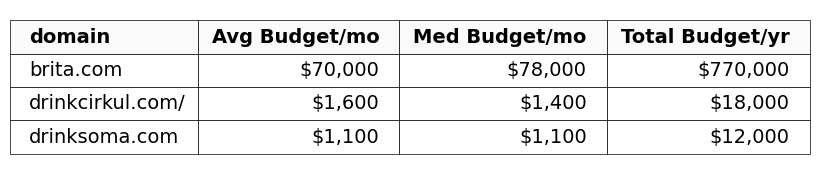

In [65]:
semrush_df = create_table_for_sem_budget(proposal_company_id_mapping)
filtered_semrush_df, stats_sem_budget_df, stats_sem_df = create_base_table_by_sem_budget(semrush_df)

sem_str = plot_sem_budget_table(filtered_semrush_df, stats_sem_budget_df)

In [66]:
# write to object
for index in stats_sem_df.index:
    mean_adwords_cost = stats_sem_df.loc[index, 'mean_adwords_cost'] 
    median_adwords_cost = stats_sem_df.loc[index, 'median_adwords_cost']
    sum_adwords_cost = stats_sem_df.loc[index, 'sum_adwords_cost']

    obj = objects.get(index)

    if mean_adwords_cost > 0:
        obj.avg_mth_sem_budget = mean_adwords_cost
    if median_adwords_cost > 0:
        obj.median_mth_sem_budget = median_adwords_cost
    if sum_adwords_cost > 0:
        obj.total_annual_sem_budget = sum_adwords_cost

In [67]:
# read objects
for comp, obj in objects.items():
    print("comp: ", comp)
    print(f"- avg_mth_sem_budget: {obj.avg_mth_sem_budget}")
    print(f"- median_mth_sem_budget: {obj.median_mth_sem_budget}")
    print(f"- total_annual_sem_budget: {obj.total_annual_sem_budget}")
    print("\n")

comp:  Brita
- avg_mth_sem_budget: 69921
- median_mth_sem_budget: 78070
- total_annual_sem_budget: 769140


comp:  Drinkcirkul
- avg_mth_sem_budget: 1610
- median_mth_sem_budget: 1439
- total_annual_sem_budget: 17718


comp:  Drinksoma
- avg_mth_sem_budget: 1109
- median_mth_sem_budget: 1052
- total_annual_sem_budget: 12201


comp:  Hydroslife
- avg_mth_sem_budget: 0
- median_mth_sem_budget: 0
- total_annual_sem_budget: 0




## Lowest SEM budget

In [68]:
# which company has the lowest ad budget?

sem_df = stats_sem_df.copy()
overall_lowest_ad_budget_comp = get_index_with_lowest_value(sem_df, 'mean_adwords_cost')
print("overall_lowest_ad_budget_comp: ", overall_lowest_ad_budget_comp)
print("\n")

write_to_single_obj_company('is_overall_lowest_ad_budget', overall_lowest_ad_budget_comp, 1)

overall_lowest_ad_budget_comp:  Drinksoma


Brita 
 - is_overall_lowest_ad_budget: 0
Drinkcirkul 
 - is_overall_lowest_ad_budget: 0
Drinksoma 
 - is_overall_lowest_ad_budget: 1
Hydroslife 
 - is_overall_lowest_ad_budget: 0


## Highest SEM budget

In [69]:
# which company has the highest ad budget?

sem_df = stats_sem_df.copy()
overall_highest_ad_budget_comp = get_index_with_highest_value(sem_df, 'mean_adwords_cost')
print("overall_highest_ad_budget_comp: ", overall_highest_ad_budget_comp)
print("\n")

write_to_single_obj_company('is_overall_highest_ad_budget', overall_highest_ad_budget_comp, 1)

overall_highest_ad_budget_comp:  Brita


Brita 
 - is_overall_highest_ad_budget: 1
Drinkcirkul 
 - is_overall_highest_ad_budget: 0
Drinksoma 
 - is_overall_highest_ad_budget: 0
Hydroslife 
 - is_overall_highest_ad_budget: 0


## Monthly changes

In [70]:
sem_df = filtered_semrush_df.copy(deep=True)

sem_df['company'] = sem_df['domain'].apply(lambda x: map_domain_to_company(x, company_list))

sem_df.head()

searchmonth  searchyear  averageorganicrank  monthlypaidclicks  \
474            6        2023                50.8            47950.0   
475            6        2023                49.5              300.0   
476            6        2023                47.5               21.0   
477            6        2023                67.1             1707.0   
478            7        2023                51.4            37760.0   

     averageadrank  totalorganicresults  monthlybudget  monthlyorganicvalue  \
474            0.0                18530       82810.00              66890.0   
475            0.0                 2737         876.80               6609.0   
476            0.0                  890          78.71               2925.0   
477            0.0                22670        2703.00              19170.0   
478            0.0                18830       83720.00              66760.0   

     totaladspurchased  monthlyorganicclicks  strength  totalinverserank  \
474               5306               39340.0        41            262100   
475                145               12200.0        33             34940   
476                 72                 879.0        30             11110   
477                493               15060.0        37            111200   
478               5197               39160.0        41            259100   

               domain   yyyymm                        dt  adwords_cost  \
474         brita.com  2023-06 2023-06-01 00:00:00+00:00      82810.00   
475     drinksoma.com  2023-06 2023-06-01 00:00:00+00:00        876.80   
476    hydroslife.com  2023-06 2023-06-01 00:00:00+00:00         78.71   
477  drinkcirkul.com/  2023-06 2023-06-01 00:00:00+00:00       2703.00   
478         brita.com  2023-07 2023-07-01 00:00:00+00:00      83720.00   

          cpc                                                 id      company  
474  1.727007  brita.com_d13SWUzDlOQaeFVnUNsC_9YJQWolIoQ2coRM...        Brita  
475  2.922667  drinksoma.com_19nGuLBeKDT2Np1d9QKk_9YJQWolIoQ2...    Drinksoma  
476  3.748095  hydroslife.com_iCQESooXqodU9IjJiUnL_9YJQWolIoQ...   Hydroslife  
477  1.583480  drinkcirkul.com/_c6Yl5sqDNnW332qJSwXQ_9YJQWolI...  Drinkcirkul  
478  2.217161  brita.com_d13SWUzDlOQaeFVnUNsC_9YJQWolIoQ2coRM...        Brita

In [71]:
# how much was the m-o-m sem ad spend?
 
comp_sem_df = pd.pivot_table(
    sem_df, 
    index=['company'], 
    columns='yyyymm', 
    values='adwords_cost', 
    aggfunc='sum'
)
comp_sem_df = comp_sem_df.fillna(0).round().astype(int)

with pd.option_context('display.max_columns', None): 
    display(comp_sem_df)
    write_to_obj_company(comp_sem_df, "mth_sem_budget")


yyyymm       2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
company                                                                      
Brita          82810    83720    83500    72660    78470    78070    83210   
Drinkcirkul     2703     2774     2770     2196     2349     1439     1107   
Drinksoma        877      906     1052     1046      980     1137     1479   
Hydroslife        79       68       41       15       17       15       25   

yyyymm       2024-01  2024-02  2024-03  2024-04  
company                                          
Brita          74180    49790    47470    35260  
Drinkcirkul      794      896      307      384  
Drinksoma       1357     1224     1160      984  
Hydroslife         0        2        0        0

Brita 
 - mth_sem_budget: 35260
Drinkcirkul 
 - mth_sem_budget: 384
Drinksoma 
 - mth_sem_budget: 984
Hydroslife 
 - mth_sem_budget: 0


In [72]:
# what is the m-o-m %change in sem budget
 
comp_sem_pct_df = sem_df.copy(deep=True)
comp_sem_pct_df = comp_sem_pct_df.sort_values(by=['company', 'yyyymm']).reset_index(drop=True)

comp_sem_pct_df['pct_sum_change'] = comp_sem_pct_df['adwords_cost'].pct_change().round(2) * 100 

comp_sem_pct_df = pd.pivot_table(
    comp_sem_pct_df, 
    index=['company'], 
    columns='yyyymm', 
    values='pct_sum_change', 
    aggfunc='sum'
)
comp_sem_pct_df = comp_sem_pct_df.iloc[: , 1:]
comp_sem_pct_df.replace([np.inf, -np.inf], np.nan, inplace=True)
comp_sem_pct_df = comp_sem_pct_df.fillna(0).astype('int64')

with pd.option_context('display.max_columns', None): 
    display(comp_sem_pct_df)
    write_to_obj_company(comp_sem_pct_df, "mth_sem_budget_pct_change")

yyyymm       2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  2024-01  \
company                                                                      
Brita              1        0      -13        8       -1        7      -11   
Drinkcirkul        3        0      -21        7      -39      -23      -28   
Drinksoma          3       16       -1       -6       16       30       -8   
Hydroslife       -14      -40      -63       13      -14       68     -100   

yyyymm       2024-02  2024-03  2024-04  
company                                 
Brita            -33       -5      -26  
Drinkcirkul       13      -66       25  
Drinksoma        -10       -5      -15  
Hydroslife         0     -100        0

Brita 
 - mth_sem_budget_pct_change: -26
Drinkcirkul 
 - mth_sem_budget_pct_change: 25
Drinksoma 
 - mth_sem_budget_pct_change: -15
Hydroslife 
 - mth_sem_budget_pct_change: 0


# Read objects

In [73]:
latest_month_data = ""
for comp, obj in objects.items():
  latest_month_data += read_object_data(comp, obj)
  latest_month_data += "\n"

print(latest_month_data)

company: Brita
has_probable_platform: 1
probable_platforms: ['Bing']
platform_active_count: 2
has_top_ad_platform: 1
has_platform_activity_changes: 0
platform_activity_changes: []
platform_active_months: [('Google', 12), ('Meta', 2)]
platform_inactive_months: []
overall_inactive_months: 0
platform_ad_count: [('Google', 35), ('Meta', 18)]
platform_ad_count_pct_change: [('Meta', 200)]
platform_ad_count_pct_dist: [('Google', 66), ('Meta', 34)]
overall_ad_count: 53
is_overall_highest_ad_count: 0
has_format_activity_changes: 1
format_activity_changes: [('video', 1)]
platform_format_activity_changes: {'Meta': [('video', 1)]}
platform_format_ad_count: {'Meta': [('image_single', 17), ('video', 1)]}
platform_format_ad_count_pct_change: {'Meta': [('image_single', 183)]}
avg_mth_sem_budget: 69921
median_mth_sem_budget: 78070
total_annual_sem_budget: 769140
is_overall_lowest_ad_budget: 0
is_overall_highest_ad_budget: 1
is_significant_ad_count_change: 0
is_significant_budget_change: 0
mth_sem_budge

# Generate graphs

In [74]:
with pd.option_context('display.max_columns', None): 
    display(pltf_df.head(2))

month  count  probability  is_active      company platform
2 2023-06-01    3.0          1.0        1.0  Drinkcirkul   Google
3 2023-06-01  116.0          1.0        1.0        Brita   Google

In [75]:
with pd.option_context('display.max_columns', None): 
    display(sem_df.head(2))

searchmonth  searchyear  averageorganicrank  monthlypaidclicks  \
474            6        2023                50.8            47950.0   
475            6        2023                49.5              300.0   

     averageadrank  totalorganicresults  monthlybudget  monthlyorganicvalue  \
474            0.0                18530        82810.0              66890.0   
475            0.0                 2737          876.8               6609.0   

     totaladspurchased  monthlyorganicclicks  strength  totalinverserank  \
474               5306               39340.0        41            262100   
475                145               12200.0        33             34940   

            domain   yyyymm                        dt  adwords_cost       cpc  \
474      brita.com  2023-06 2023-06-01 00:00:00+00:00       82810.0  1.727007   
475  drinksoma.com  2023-06 2023-06-01 00:00:00+00:00         876.8  2.922667   

                                                    id    company  
474  brita.com_d13SWUzDlOQaeFVnUNsC_9YJQWolIoQ2coRM...      Brita  
475  drinksoma.com_19nGuLBeKDT2Np1d9QKk_9YJQWolIoQ2...  Drinksoma

In [76]:
# filter for last 3 months data only
_plot_pltf_df = pltf_df.copy(deep=True)
_plot_pltf_df = _plot_pltf_df[(_plot_pltf_df['month'] >= three_month_ago_dt) & (_plot_pltf_df['month'] < as_of_month_dt)]
_plot_pltf_df = _plot_pltf_df.sort_values(by=['month', 'company', 'platform'])

_plot_sem_df = sem_df.copy(deep=True)
_plot_sem_df['month'] = pd.to_datetime(sem_df['yyyymm'] + "-01")
_plot_sem_df = _plot_sem_df[(_plot_sem_df['month'] >= three_month_ago_dt) & (_plot_sem_df['month'] < as_of_month)]
_plot_sem_df = _plot_sem_df.sort_values(by=['month', 'company'])

# exclude lead_domain
_plot_pltf_df = _plot_pltf_df[_plot_pltf_df['company'].str.lower() != lead_company]
_plot_sem_df = _plot_sem_df[_plot_sem_df['company'].str.lower() != lead_company]


print("last three months: ")
print("_plot_pltf_df: ", _plot_pltf_df.month.unique())
print("_plot_sem_df: ", _plot_sem_df.month.unique())

_plot_sem_df.head(2)


last three months: 
_plot_pltf_df:  <DatetimeArray>
['2024-03-01 00:00:00', '2024-04-01 00:00:00', '2024-05-01 00:00:00']
Length: 3, dtype: datetime64[ns]
_plot_sem_df:  <DatetimeArray>
['2024-03-01 00:00:00', '2024-04-01 00:00:00']
Length: 2, dtype: datetime64[ns]


searchmonth  searchyear  averageorganicrank  monthlypaidclicks  \
510            3        2024                43.6            19110.0   
512            3        2024                56.8                1.0   

     averageadrank  totalorganicresults  monthlybudget  monthlyorganicvalue  \
510            1.2                46380        47470.0             136000.0   
512            1.1                33710          307.1              13770.0   

     totaladspurchased  monthlyorganicclicks  strength  totalinverserank  \
510               4072               83520.0        46            811800   
512                281               18010.0        37            362700   

               domain   yyyymm                        dt  adwords_cost  \
510         brita.com  2024-03 2024-03-01 00:00:00+00:00       47470.0   
512  drinkcirkul.com/  2024-03 2024-03-01 00:00:00+00:00         307.1   

           cpc                                                 id  \
510    2.48404  brita.com_d13SWUzDlOQaeFVnUNsC_9YJQWolIoQ2coRM...   
512  307.10000  drinkcirkul.com/_c6Yl5sqDNnW332qJSwXQ_9YJQWolI...   

         company      month  
510        Brita 2024-03-01  
512  Drinkcirkul 2024-03-01

In [77]:
# plot bar and line combo graphs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

if len(_plot_pltf_df) > 0:
    companies = _plot_pltf_df.company.unique()

    # DEFINE SUBPLOT GRID BASED ON COMPANIES
    ncols = 2  # Adjust as needed
    max_plots = ncols * math.ceil(len(companies) / ncols)  # Maximum number of subplots

    # CREATE SUBPLOT TITLES (truncate if needed)
    subplot_titles = companies[:max_plots]

    # GENERATE SUBPLOT SPECS (all with secondary_y for SEM budget)
    specs_list = [[{"secondary_y": True}] * ncols for _ in range(max_plots // ncols)]
    nrows = len(specs_list)

    fig = make_subplots(
        rows=nrows, 
        cols=ncols,
        subplot_titles=subplot_titles,
        specs=specs_list,
        print_grid=True,
    )

    # CREATE PLOTS
    is_showlegend_list = []
    plot_index = 0  
    for i, c in enumerate(companies):
        if plot_index >= max_plots: 
            break

        row_num = (plot_index // ncols) + 1
        col_num = (plot_index % ncols) + 1

        plot_df = _plot_pltf_df[_plot_pltf_df['company'] == c]
        plot_sem_df = _plot_sem_df[_plot_sem_df['company'] == c]

        # number of ads
        # plotly colors: https://plotly.com/python/discrete-color/
        color_dict = {
            # ad platforms
            "Google":"#FBBC05",
            "Bing":"#B2B28D",
            "Meta":"#80C0FD",
            "LinkedIn":"#0077B5",
            "TikTok":"#FE2C55",

            # ad budget
            "SEM": "#7F7F7F",
        }

        for up in plot_df['platform'].unique():
            up_plot_df = plot_df[plot_df['platform'] == up]
            color_palette = color_dict.get(up, "red")
            if up not in is_showlegend_list:
                is_showlegend = True
                is_showlegend_list.append(up)
            else:
                is_showlegend = False

            fig.add_trace(
                go.Bar(
                    x=up_plot_df['month'], 
                    y=up_plot_df['count'], 
                    name=up, 
                    marker=dict(color=color_palette), 
                    legendgroup=color_palette, 
                    showlegend=is_showlegend,
                    # text=up_plot_df['count'],
                    # textposition='auto',
                ),
                secondary_y=False,
                row=row_num,
                col=col_num,
            )
            fig.update_yaxes(title_text="Number of Ads", title_font = {"size": 12}, tickfont=dict(size=11), secondary_y=False)

        # sem budget
        if len(plot_sem_df) > 0:
            fig.add_trace(
                go.Scatter(x=plot_sem_df['month'], y=pd.to_numeric(plot_sem_df['monthlybudget']), marker=dict(color=color_dict.get("SEM")), showlegend=False),
                secondary_y=True,
                row=row_num,
                col=col_num,
            )
            fig.update_yaxes(title_text="SEM Budget (USD)", title_font = {"size": 12}, tickfont=dict(size=11), secondary_y=True)
    
        plot_index += 1
    
    fig.update_layout(
        barmode='stack', 
        title=dict(
            text=f"<b>Competitors' Monthly Number of Active Ads and SEM Budget ({one_month_ago})</b>", 
            font=dict(size=18)
        ),
        autosize=True,
        # minreducedwidth=250,
        # minreducedheight=250,
        height=(nrows*200)+50, 
        # width=1000, 
        legend=dict(orientation="h"),
        # paper_bgcolor='rgba(0,0,0,0)',
        # plot_bgcolor='#ffffff',
        legend_traceorder="normal",
        **{
            "xaxis": {"autorange": True}, 
            "yaxis": {"autorange": True}, 
            "margin": {"l": 80, "r": 20, "t": 80, "b": 80},  # Adjust margins for spacing
            "paper_bgcolor": "white",  # Adjust background color
            "plot_bgcolor": "white",  # Adjust plot area background color
            "bargap": 0.3,  # Adjust spacing between bars within subplots (optional)
        }
    )

    # time formatting: https://d3js.org/d3-time-format
    # tickformat = '%Y-%m' for YYYY-MM
    fig.update_xaxes(tickformat = '%b-%y', dtick='M1') 

    fig.update_yaxes(automargin='left+top')

    # subplot title: company name
    fig.update_annotations(font_size=14)

    fig.show()


    # EXPORT IMAGE
    _IMAGE_BUCKET = "kaya-apps-00-public"
    comp_num_ads_and_sem_budget_per_month_storage_url = save_and_upload_fig(
        fig,
        f"/tmp/comp_num_ads_and_sem_budget_per_month_{one_month_ago_yyyymm}.png",
        proposal_id,
        proposal_company_id,
        _IMAGE_BUCKET
    )

This is the format of your plot grid:
[ (1,1) x,y,y2   ]  [ (1,2) x2,y3,y4 ]
[ (2,1) x3,y5,y6 ]  [ (2,2) x4,y7,y8 ]



WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/comp_num_ads_and_sem_budget_per_month_202405.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/iCQESooXqodU9IjJiUnL/comp_num_ads_and_sem_budget_per_month_202405.png.


# Write Monthly Summary

## By Competitors

In [78]:
company_list_lower = {name.lower(): name for name in company_list}

print("lead_domain: ", lead_domain)
print("company_list: ", company_list)
print("company_list_lower: ", company_list_lower)

lead_domain:  hydroslife.com
company_list:  ['Brita', 'Drinkcirkul', 'Drinksoma', 'Hydroslife']
company_list_lower:  {'brita': 'Brita', 'drinkcirkul': 'Drinkcirkul', 'drinksoma': 'Drinksoma', 'hydroslife': 'Hydroslife'}


In [79]:
def summarize_company_ad_distribution(comp, obj):
  company_summary = ""
  overall_ad_count = int_to_accounting_format(obj.overall_ad_count)
  company_summary += f"Total active ads: {overall_ad_count}"

  if obj.platform_active_count == 0:
      company_summary += "\n"
      company_summary += f"- {comp} has been inactive in paid marketing in the past {obj.overall_inactive_months} month{'s' if obj.overall_inactive_months > 1 else ''}"
  
  else:
      platform_ad_dist_dict = {x: y for x, y in obj.platform_ad_count_pct_dist}

      platform_summaries_list = []
      for p in obj.platform_ad_count:
        platform = p[0]
        platform_ad_dist = platform_ad_dist_dict[platform]
      
        platform_summary = f"{platform}: {platform_ad_dist}%"
        platform_summaries_list.append(platform_summary)
      
      if obj.has_probable_platform == 1:
        probable_platforms_str = [f"{p}*" for p in obj.probable_platforms]
        platform_summaries_list.extend(probable_platforms_str)

      platform_summaries = '; '.join(platform_summaries_list)

      company_summary += " (" + platform_summaries + ")"

  return company_summary


def summarize_company_ad_format_list(comp, obj):
  ad_format_list = list(obj.platform_format_ad_count.values())[0]

  # sort list of tuple in reverse order based on number of ads
  sorted_list = sorted(ad_format_list, key=lambda x: x[1], reverse=True)

  # extract list of ad formats
  sorted_ad_format_list = [item[0].replace("_", " ") for item in sorted_list]
  sub_ad_format_list = sorted_ad_format_list[1:]
  sub_ad_format_str = join_list_of_str_with_and(sub_ad_format_list, ",")

  company_summary = ""
  company_summary += f"primarily running {sorted_ad_format_list[0]} ads, followed by these ad formats: {sub_ad_format_str}"

  return company_summary

  
def summarize_company_platform_change(comp, obj):
  company_summary = ""
  if obj.platform_activity_changes:
    platform_changes_list = []

    for pltf_chg in obj.platform_activity_changes:
      platform = pltf_chg[0]
      change = pltf_chg[1]

      if change == 1:
        platform_change = f"started running {platform} ads"
        platform_changes_list.append(platform_change)
    
      elif change == -1:
        platform_change = f"stopped {platform} ads"
        platform_changes_list.append(platform_change)
    
      else:
        platform_change = f"while maintaining existing {platform} ads"
        platform_changes_list.append(platform_change)
    
    platform_changes = join_list_of_str_with_and(platform_changes_list, ",")
    company_summary += f"{comp}" + platform_changes
    company_summary += f"These suggest a change in channel mix strategy, would be worth keeping an eye on"

  else:
    if obj.platform_active_count == 0:
      pass
    
    else:
      platforms_list = [p[0] for p in obj.platform_ad_count_pct_dist]
      platforms = join_list_of_str_with_and(platforms_list, ",")

      average_ad_count_dist = mean([d[1] for d in obj.platform_ad_count_pct_dist])
      highest_ad_count_dist = max(obj.platform_ad_count_pct_dist, key=lambda x: x[1])
      highest_ad_count_platform = highest_ad_count_dist[0]
      highest_ad_count_platform_dist = highest_ad_count_dist[1]

      if obj.platform_active_count == 1:
        company_summary += f"{comp}'s focus remained exclusively on {platforms} ads"

        if platforms not in ("Google", "Bing"):
          summary_company_ad_format = summarize_company_ad_format_list(comp, obj)
          print("summary_company_ad_format: ", summary_company_ad_format)
          company_summary += f", {summary_company_ad_format}"
        
        else:
          if obj.avg_mth_sem_budget > 0:
            avg_mth_sem_budget = int_to_accounting_format(obj.avg_mth_sem_budget)
            company_summary += f", with average monthly SEM budget estimated at ${avg_mth_sem_budget}"
        
      elif obj.platform_active_count > 1:
        company_summary += f"{comp}'s focus remained on {platforms} ads"

        # flag as stronger emphasis on platform if distribution is 20% higher than average
        if highest_ad_count_platform_dist > (average_ad_count_dist * 1.2):
            company_summary += f"; emphasizing on {highest_ad_count_platform} ads"

  return company_summary


def summarize_company_ad_count(comp, obj):
  paid_social_dict = {}

  # increased/decreased significantly if exceeds 40% m-o-m change
  if obj.platform_ad_count_pct_change:

    platform_ad_count_dict = {} 
    for pltf_ad in obj.platform_ad_count:
      platform = pltf_ad[0]
      ad_count = pltf_ad[1]
      platform_ad_count_dict[platform] = ad_count

    for pltf_chg in obj.platform_ad_count_pct_change:
      platform = pltf_chg[0]
      change = pltf_chg[1]
      ad_count = platform_ad_count_dict.get(platform, 0)
      
      if platform not in ["Google", "Bing"]:

        platform_changes_list = paid_social_dict.get(platform, [])

        if 0 < change < 30:
          platform_change = f"{platform} ads increased by {change}% to {ad_count}"
          platform_changes_list.append(platform_change)
          is_significant_ad_count_change = 0
        
        elif change >= 30:
          platform_change = f"{platform} ads increased significantly by {change}% to {ad_count}"
          platform_changes_list.append(platform_change)
          is_significant_ad_count_change = 1
      
        elif -30 < change < 0:
          platform_change = f"{platform} ads decreased by {change}% to {ad_count}"
          platform_changes_list.append(platform_change)
          is_significant_ad_count_change = 0
      
        elif change <= -30:
          platform_change = f"{platform} ads decreased significantly by {change}% to {ad_count}"
          platform_changes_list.append(platform_change)
          is_significant_ad_count_change = 1

        # write to object
        if is_significant_ad_count_change == 1:
          write_to_single_obj_company("is_significant_ad_count_change", comp, 1)
      
          print("\n\n")
          print("------")

        # update dict 
        if platform_changes_list:
          paid_social_dict[platform] = platform_changes_list

  # does not report if no changes or unavailable
  else:
    pass
  
  return paid_social_dict


# increased/decreased significantly if exceeds 30% m-o-m change
def summarize_company_ad_format_count(comp, obj, paid_social_dict):
  if obj.platform_format_ad_count and obj.platform_format_ad_count_pct_change:

    platforms = [k for k in obj.platform_format_ad_count_pct_change.keys() if k not in ["Google", "Bing"]]

    if platforms:
        for platform in platforms:
          summary_str = ""

          platform_list = paid_social_dict.get(platform, [])

          format_tup_list = obj.platform_format_ad_count_pct_change.get(platform, {})
          platform_format_ad_count = obj.platform_format_ad_count.get(platform, {})

          # process format change and if significant
          # format_changes = []
          format_changes_dict = {}
          for f in format_tup_list:
            format = f[0].replace("_", " ")
            change = f[1]

            num_ads = [a[1] for a in platform_format_ad_count if a[0] == f[0]][0]

            if change >= 30:
              change_description = "increased"
              format_changes = format_changes_dict.get(change_description, [])

              format_change = f"{format} ads by {change}% to {num_ads} ads"
              format_changes.append(format_change)
              format_changes_dict[change_description] = format_changes
          
            elif change <= -30:
              change_description = "decreased"
              format_changes = format_changes_dict.get(change_description, [])

              format_change = f"{format} ads by {change}% to {num_ads} ads"
              format_changes.append(format_change)
              format_changes_dict[change_description] = format_changes
            
            else:
              change_description = "remained"
              format_changes = format_changes_dict.get(change_description, [])

              format_change = f"{format}"
              format_changes.append(format_change)
              format_changes_dict[change_description] = format_changes
          
          if format_changes_dict:
            # sort dict based on importance
            change_order = ["increased", "decreased", "remained"]
            ordered_dict = {}
            for item in change_order:
                if item in format_changes_dict:
                  ordered_dict[item] = format_changes_dict[item]

            for change, format_changes in ordered_dict.items():
              if change in ("increased", "decreased"):
                summary_str += f"It significantly {change} its number of "

                all_format_changes_str = join_list_of_str_with_and(format_changes, ";")
                summary_str += all_format_changes_str

                if len(format_changes_dict) > 1:
                  summary_str += ". "
          
              elif change == "remained":
                all_format_changes_str = join_list_of_str_with_and(format_changes, ",")
                if len(format_changes) > 1:
                  is_plural = "s remain"
                else:
                  is_plural = " remains"
                
                summary_str += f"Its number of ads across {all_format_changes_str} ad format{is_plural} rather consistent from the previous month"
          
          # update main dict
          platform_list.append(summary_str)
          paid_social_dict[platform] = platform_list

  else:
    pass

  return paid_social_dict


def summarize_company_format_change(comp, obj):
  company_summary = ""
  if obj.format_activity_changes:
    format_changes_dict = {}

    for format_chg in obj.format_activity_changes:
      format = format_chg[0]
      change = format_chg[1]

      format_change_mapping = {
        1: "started",
        -1: "stopped",
        0: "maintained",
      }
      format_change = format_change_mapping.get(change, 0)
      changes_list = format_changes_dict.get(format_change, [])

      changes_list.append(f"{format}")
      format_changes_dict[format_change] = changes_list
    
    if format_changes_dict:
      all_format_changes_list = []
      for change, format_changes_list in format_changes_dict.items():
        format_changes = join_list_of_str_with_and(format_changes_list, ",") + " ads"
        all_format_changes_list.append(format_changes)

      all_format_changes_str = join_list_of_str_with_and(all_format_changes_list, ";")
      company_summary += f"{comp} {change} running " + all_format_changes_str

  elif obj.platform_active_count > 0:
    if len(obj.platform_activity_changes) == 0:
      company_summary += f"Ad platforms and formats used remained similar to previous month"
    else:
      company_summary += f"Ad format used remained similar to previous month"

  return company_summary


def summarize_company_platform_format_change(comp, obj, paid_social_dict):
  if obj.platform_format_activity_changes:
    format_start = []
    format_stop = []
    format_maintain = []

    for platform, format_tup_list in obj.platform_format_activity_changes.items():
      if platform not in ["Google", "Bing"]:
        platform_list = paid_social_dict.get(platform, [])
        
        for f in format_tup_list:
          format = f[0].replace("_", " ")
          change = f[1]

          format_change = f"{format} ads"

          if change == 1:
            format_start.append(format_change)
        
          elif change == -1:
            format_stop.append(format_change)
        
          else:
            format_maintain.append(format_change)

        format_changes = []
        if format_start:
          format_changes_str = join_list_of_str_with_and(format_start, ",")
          format_changes.append(f"launched new ad formats {format_changes_str}")
        
        if format_stop:
          format_changes_str = join_list_of_str_with_and(format_stop, ",")
          format_changes.append(f"stopped running {format_changes_str}")

        if format_maintain:
          format_changes_str = join_list_of_str_with_and(format_maintain, ",")
          format_changes.append(f"while maintaining existing {format_changes_str}")

        all_format_changes_str = "It "
        all_format_changes_str += join_list_of_str_with_and(format_changes, ";")
        platform_list.append(all_format_changes_str)
      
      if platform_list:
        paid_social_dict[platform] = platform_list

    else:
      pass

  return paid_social_dict


def summarize_company_sem_change(comp, obj):
  company_summary = ""

  platforms_list = [p[0] for p in obj.platform_ad_count_pct_dist]

  # increased/decreased significantly if exceeds 10% m-o-m change
  if "Google" in platforms_list:
    
    if 0 < obj.mth_sem_budget_pct_change < 10:
      mth_sem_budget = int_to_accounting_format(obj.mth_sem_budget)
      company_summary += f"Paid Search: {comp}'s monthly SEM budget is estimated to have increased by {obj.mth_sem_budget_pct_change}% to ${mth_sem_budget}"

    elif obj.mth_sem_budget_pct_change >= 10:
      mth_sem_budget = int_to_accounting_format(obj.mth_sem_budget)
      company_summary += f"Paid Search: {comp} saw a significant increase in its monthly SEM budget allocation by {obj.mth_sem_budget_pct_change}% to ${mth_sem_budget}"

    elif -10 < obj.mth_sem_budget_pct_change < 0:
      mth_sem_budget = int_to_accounting_format(obj.mth_sem_budget)
      company_summary += f"Paid Search: {comp}'s monthly SEM budget saw an estimated dip of {obj.mth_sem_budget_pct_change}% to ${mth_sem_budget}"

    elif obj.mth_sem_budget_pct_change <= -10:
      mth_sem_budget = int_to_accounting_format(obj.mth_sem_budget)
      company_summary += f"Paid Search: {comp}'s monthly SEM budget dipped significantly by {obj.mth_sem_budget_pct_change}% to ${mth_sem_budget}"

  # does not report if no changes or unavailable
  else:
    pass
  
  return company_summary


def map_lead_domain_to_company(lead_domain, company_list):
    extracted_domain = lead_domain.split('.', 1)[0]
    extracted_domain = extracted_domain.lower()

    company_list_lower = {name.lower(): name for name in company_list}
    lead_company_name = company_list_lower.get(extracted_domain, None)

    return lead_company_name


# WRITE SUMMARY: BY COMPANY
lead_company = map_lead_domain_to_company(lead_domain, company_list)
has_probable_platform_flag = 0

summary_company = "What Your Competitors Were Up To 🔎 \n\n"
for comp, obj in objects.items():
  if comp != lead_company and obj.platform_active_count > 0:
    paid_social_dict = {}

    summary_company += comp + "\n"

    summary_company_ad_distribution = summarize_company_ad_distribution(comp, obj) 
    if summary_company_ad_distribution:
      summary_company += "- " + summary_company_ad_distribution + "\n"
    
    if obj.has_probable_platform == 1:
      has_probable_platform_flag = 1

    summary_company_platform_change = summarize_company_platform_change(comp, obj)
    if summary_company_platform_change:
      summary_company += "- " + summary_company_platform_change + "\n"

    summary_company_format_change = summarize_company_format_change(comp, obj) 
    if summary_company_format_change:
      summary_company += "- " + summary_company_format_change + "\n"

    # summarize by paid social
    paid_social_dict = summarize_company_ad_count(comp, obj)    
    paid_social_dict = summarize_company_platform_format_change(comp, obj, paid_social_dict)
    paid_social_dict = summarize_company_ad_format_count(comp, obj, paid_social_dict)

    if paid_social_dict:
        if len(paid_social_dict) == 1:
          platform_ad_change = list(paid_social_dict.items())[0]
          platform = platform_ad_change[0]
          ad_changes_str = ". ".join(platform_ad_change[1])

          summary_company += "- Paid Social: "
          summary_company += f"On {platform}, {ad_changes_str}" + "\n"

        else:
          for platform, ad_changes in paid_social_dict.items():
            ad_changes_str = join_list_of_str_with_and(ad_changes, ",")

            summary_company += "- Paid Social: " + "\n"
            summary_company += f"On {platform}, {ad_changes_str}" + "\n"

    # summarize by paid search
    summary_company_sem_change = summarize_company_sem_change(comp, obj)
    if summary_company_sem_change:
      summary_company += "- " + summary_company_sem_change + "\n"

    summary_company += "\n"
  
  else:
    pass

if has_probable_platform_flag == 1:
  summary_company += "* = May be running ads"

Brita 
 - is_significant_ad_count_change: 1
Drinkcirkul 
 - is_significant_ad_count_change: 0
Drinksoma 
 - is_significant_ad_count_change: 0
Hydroslife 
 - is_significant_ad_count_change: 0



------
Brita 
 - is_significant_ad_count_change: 1
Drinkcirkul 
 - is_significant_ad_count_change: 1
Drinksoma 
 - is_significant_ad_count_change: 0
Hydroslife 
 - is_significant_ad_count_change: 0



------


### Summary output

In [80]:
print(summary_company)

What Your Competitors Were Up To 🔎 

Brita
- Total active ads: 53 (Google: 66%; Meta: 34%; Bing*)
- Brita's focus remained on Google and Meta ads; emphasizing on Google ads
- Brita started running video ads
- Paid Social: On Meta, Meta ads increased significantly by 200% to 18. It launched new ad formats video ads. It significantly increased its number of image single ads by 183% to 17 ads
- Paid Search: Brita's monthly SEM budget dipped significantly by -26% to $35,260

Drinkcirkul
- Total active ads: 77 (Google: 3%; Meta: 97%)
- Drinkcirkul's focus remained on Google and Meta ads; emphasizing on Meta ads
- Ad platforms and formats used remained similar to previous month
- Paid Social: On Meta, Meta ads increased significantly by 127% to 75. It significantly increased its number of image single ads by 148% to 62 ads and video ads by 71% to 12 ads
- Paid Search: Drinkcirkul saw a significant increase in its monthly SEM budget allocation by 25% to $384

Drinksoma
- Total active ads: 19 

## By Overall Landscape

In [81]:
summary_dict = {}
competitor_rank = []
competitor_top_ad_platform = []
competitor_sem = []
competitor_platform_change = []
competitor_format_change = []
competitor_platform_format_no_change = []

competitor_sig_chg_ad_count = []
competitor_sig_chg_sem = []
competitor_sig_chg_sem_increase = []
competitor_sig_chg_sem_decrease = []

for comp, obj in objects.items():

    if comp != lead_company:

        # competitor ranking
        comp_rank = (comp, obj.overall_ad_count)
        competitor_rank.append(comp_rank)

        # top ad platform
        if obj.has_top_ad_platform == 1:
            competitor_top_ad_platform.append(comp)

        # sem budget
        if obj.avg_mth_sem_budget > 0:
            comp_sem = (comp, obj.avg_mth_sem_budget)
            competitor_sem.append(comp_sem)

        # platform change
        if obj.platform_activity_changes:
            include_platform_list = []
            exclude_platform_list = []
            maintain_platform_list = []
            for pltf_chg in obj.platform_activity_changes:
                platform = pltf_chg[0]
                change = pltf_chg[1]

                if change == 1:
                    platform_change = f"{platform} ads"
                    include_platform_list.append(comp_pltf_change)
                
                elif change == -1:
                    platform_change = f"{platform} ads"
                    exclude_platform_list.append(platform_change)
                
                else:
                    platform_change = f"{platform} ads"
                    maintain_platform_list.append(platform_change)
                
            # join the lists by change directions
            platform_changes_list = []
            
            if include_platform_list:
                change_str = join_list_of_str_with_and(include_platform_list, ",")
                platform_changes_str = "launched" + change_str
                platform_changes_list.append(platform_changes_str)
            
            if exclude_platform_list:
                change_str = join_list_of_str_with_and(exclude_platform_list, ",")
                platform_changes_str = "stopped running" + change_str
                platform_changes_list.append(platform_changes_str)
            
            if maintain_platform_list:
                change_str = join_list_of_str_with_and(maintain_platform_list, ",")
                platform_changes_str = "while maintaining" + change_str
                platform_changes_list.append(platform_changes_str)

            # process into readable format
            platform_changes = '; '.join(platform_changes_list)

            comp_pltf_change = (comp, platform_changes)
            competitor_platform_change.append(comp_pltf_change)
        
        # format change
        elif obj.has_format_activity_changes == 1:
            competitor_format_change.append(comp)
        
        # platform and format no change
        elif obj.has_platform_activity_changes == 0 and obj.has_format_activity_changes == 0:
            competitor_platform_format_no_change.append(comp)
        
        
        # significant change in ad count
        if obj.is_significant_ad_count_change == 1:
            competitor_sig_chg_ad_count.append(comp)
            
        # significant change in sem budget
        if obj.is_significant_budget_change == 1:
            if obj.mth_sem_budget_pct_change > 0:
                comp_sem_change = (comp, obj.mth_sem_budget_pct_change)
                competitor_sig_chg_sem_increase.append(comp_sem_change)

            elif obj.mth_sem_budget_pct_change < 0:
                comp_sem_change = (comp, obj.mth_sem_budget_pct_change)
                competitor_sig_chg_sem_decrease.append(comp_sem_change)

            competitor_sig_chg_sem.append(comp)


# competitor ranking
if competitor_rank:
    competitor_rank = sorted(competitor_rank, key=lambda x: x[1], reverse=True)

    # dominant competitor
    dominant_competitor = competitor_rank[0][0]
    dominant_competitor_ad_count = competitor_rank[0][1]
    dominant_competitor_ad_platform_list = [p[0] for p in objects.get(dominant_competitor).platform_ad_count]
    dominant_competitor_ad_platforms = join_list_of_str_with_and(dominant_competitor_ad_platform_list, ",")

    if objects.get(dominant_competitor).has_probable_platform == 1:
        probable_platform_list = objects.get(dominant_competitor).probable_platforms
        probable_platforms = join_list_of_str_with_and(probable_platform_list, ",")

        dominant_competitor_ad_platforms += f"; and potentially running {probable_platforms} ads"
    
    # write to dict
    summary_dict['dominant_competitor'] = dominant_competitor
    summary_dict['dominant_competitor_ad_count'] = dominant_competitor_ad_count
    summary_dict['dominant_competitor_ad_platforms'] = dominant_competitor_ad_platforms

    # other competitors
    other_competitors_list = []
    other_competitors_probable_list = []

    for c in competitor_rank[1:]:
        competitor = c[0]
        competitor_ad_count = c[1]

        if competitor_ad_count > 0:
            competitor_ad_count = int_to_accounting_format(competitor_ad_count)
            competitor_str = competitor + " (" + competitor_ad_count + ")"
            other_competitors_list.append(competitor_str)
        else:
            other_competitors_probable_list.append(competitor)

    if other_competitors_list:
        other_competitors = join_list_of_str_with_and(other_competitors_list, ",")

        summary_dict['other_competitors'] = other_competitors

    if other_competitors_probable_list:
        other_competitors_probable = join_list_of_str_with_and(other_competitors_probable_list, ",")

        summary_dict['other_competitors_probable'] = other_competitors_probable

    
    
    


# competitors with top ad platform
if competitor_top_ad_platform:
    n_competitor_top_ad_platform = len(competitor_top_ad_platform)
    all_competitors = len(objects) - 1
    pct_competitor_top_ad_platform = round(n_competitor_top_ad_platform / all_competitors * 100)

    # write to dict
    summary_dict['top_ad_platform'] = top_ad_platform
    summary_dict['pct_competitor_top_ad_platform'] = pct_competitor_top_ad_platform


# competitor sem
if competitor_sem:
    competitor_sem = sorted(competitor_sem, key=lambda x: x[1], reverse=False)
    lowest_sem = competitor_sem[0]
    lowest_sem_amount = int_to_accounting_format(lowest_sem[1]) # '${:,}'.format(lowest_sem[1])

    highest_sem = competitor_sem[-1]
    highest_sem_amount = int_to_accounting_format(highest_sem[1]) #'${:,}'.format(highest_sem[1])

    sem_range = f"${lowest_sem_amount} and ${highest_sem_amount}; by {lowest_sem[0]} and {highest_sem[0]}, respectively"
    # write to dict
    summary_dict['sem_range'] = sem_range


# competitor platform change
if competitor_platform_change:
    summary_dict['competitor_platform_change'] = competitor_platform_change


# competitor format change
if competitor_format_change:
    competitor_format_change_str = join_list_of_str_with_and(competitor_format_change, ",")
    summary_dict['competitor_format_change'] = f"{competitor_format_change_str} recently made changes to their ad formats" 


# competitor platform and format change
if competitor_platform_format_no_change:
    if len(competitor_platform_format_no_change) == len(objects) - 1:
        competitor_platform_format_no_change_str = "All competitors"
    else:
        competitor_platform_format_no_change_str = join_list_of_str_with_and(competitor_platform_format_no_change, ",")

    summary_dict['competitor_platform_format_no_change'] = f"{competitor_platform_format_no_change_str} continued advertising on their existing ad platforms and formats, with no major changes observed" 


# competitor significant change in ad count
if competitor_sig_chg_ad_count:
    competitor_sig_chg_ad_count = join_list_of_str_with_and(competitor_sig_chg_ad_count, ",")
    summary_dict['competitor_sig_chg_ad_count'] = f"{competitor_sig_chg_ad_count} saw significant changes in ad count last month"


# competitor significant change in sem budget
if competitor_sig_chg_sem_increase:
    competitors = [p[0] for p in competitor_sig_chg_sem_increase]
    competitors = join_list_of_str_with_and(competitors, ",")

    competitor_chg_list = []
    for c in competitor_sig_chg_sem_increase:
        competitor = str(c[0]) + " (" + str(c[1]) + ")"
        competitor_chg_list.append(competitor)

    competitor_chg = join_list_of_str_with_and(competitor_chg_list, ",")

    competitor_sig_chg_sem_increase_str = f"{competitors} increased its SEM budget last month; at {competitor_chg} respectively"
    
    summary_dict['competitor_sig_chg_sem_increase'] = competitor_sig_chg_sem_increase_str

    print("competitor_sig_chg_sem_increase: ", competitor_sig_chg_sem_increase_str)


if competitor_sig_chg_sem_decrease:
    competitors = [p[0] for p in competitor_sig_chg_sem_decrease]
    competitors = join_list_of_str_with_and(competitors, ",")

    competitor_chg_list = []
    for c in competitor_sig_chg_sem_decrease:
        competitor = str(c[1]) + "%" + " (" + str(c[0]) + ")"
        competitor_chg_list.append(competitor)

    competitor_chg = join_list_of_str_with_and(competitor_chg_list, ",")

    competitor_sig_chg_sem_decrease_str = f"Notably, {competitors} decreased its SEM budget last month; at {competitor_chg} respectively"
    
    summary_dict['competitor_sig_chg_sem_decrease'] = competitor_sig_chg_sem_decrease_str

    print("competitor_sig_chg_sem_decrease: ", competitor_sig_chg_sem_decrease_str)
        


# check output
print("dominant_competitor: ", dominant_competitor)
print("dominant_competitor_ad_count: ", dominant_competitor_ad_count)
print("dominant_competitor_ad_platforms: ", dominant_competitor_ad_platforms)
print("other_competitors: ", other_competitors)
print("top_ad_platform: ", top_ad_platform)
print("pct_competitor_top_ad_platform: ", pct_competitor_top_ad_platform)
print("sem_range: ", sem_range)
print("competitor_platform_change: ", competitor_platform_change)

print("\n\n")
print("---")

# WRITE SUMMARY: OVERALL
summary_overall = "Overall Competitive Landscape 🔥 \n\n"
dominant_competitor_ad_count = int_to_accounting_format(summary_dict['dominant_competitor_ad_count'])

if len(summary_dict.get('other_competitors_probable', "")) > 0:
    is_other_competitors_probable = f". {summary_dict['other_competitors_probable']} may also be running ads"
else:
    is_other_competitors_probable = ""

summary_overall += f"- The competitive landscape for paid marketing is dominated by {summary_dict['dominant_competitor']} based on ad count, with {dominant_competitor_ad_count} ads across {summary_dict['dominant_competitor_ad_platforms']}. This is followed by {summary_dict['other_competitors']}{is_other_competitors_probable}"
summary_overall += "\n"

if summary_dict.get('pct_competitor_top_ad_platform', 0) == 100: 
    pct_competitor_top_ad_platform = "All"
else:
    pct_competitor_top_ad_platform = f"{summary_dict['pct_competitor_top_ad_platform']}%"

summary_overall += f"- The most popular ad platform is {summary_dict['top_ad_platform']}. {pct_competitor_top_ad_platform} of your competitors have advertised on this platform"
summary_overall += "\n"

if summary_dict.get('sem_range', None): 
    summary_overall += f"- Paid search monthly budget ranges between {summary_dict['sem_range']}"
    summary_overall += "\n"

if summary_dict.get('competitor_platform_change', None): 
    if len(summary_dict['competitor_platform_change']) == 1:
        p = summary_dict['competitor_platform_change'][0]
        summary_overall += f"- {p[0]} changed it platform mix. It {p[1]}"
    else:
        competitors = [c[0] for c in competitor_platform_change]
        competitors = join_list_of_str_with_and(competitors, ",")
        summary_overall += f"- {competitors} changed their platform mixes:"
        summary_overall += "\n"

        for p in summary_dict['competitor_platform_change']:
            summary_overall += f"  - {p[0]} {p[1]}"
            summary_overall += "\n"

if summary_dict.get('competitor_format_change', None):
    summary_overall += f"- {summary_dict['competitor_format_change']}"

    if summary_dict.get('competitor_platform_format_no_change', None):
        summary_overall += f"; whereas {summary_dict['competitor_platform_format_no_change']}"
        summary_overall += "\n"
        
else:
    if summary_dict.get('competitor_platform_format_no_change', None):
        summary_overall += f"- {summary_dict['competitor_platform_format_no_change']}"           

    summary_overall += "\n"

if summary_dict.get('competitor_sig_chg_ad_count', None): 
    summary_overall += f"- {summary_dict['competitor_sig_chg_ad_count']} "
    summary_overall += "\n"

if summary_dict.get('competitor_sig_chg_sem_increase', None):
    summary_overall += f"- {summary_dict['competitor_sig_chg_sem_increase']}"
    summary_overall += "\n"
    
if summary_dict.get('competitor_sig_chg_sem_decrease', None):
    summary_overall += f"- {summary_dict['competitor_sig_chg_sem_decrease']}"
    summary_overall += "\n"

summary_overall += "\n"
summary_overall += "For more details, see below."

dominant_competitor:  Drinkcirkul
dominant_competitor_ad_count:  77
dominant_competitor_ad_platforms:  Google and Meta
other_competitors:  Brita (53) and Drinksoma (19)
top_ad_platform:  Google
pct_competitor_top_ad_platform:  100
sem_range:  $1,109 and $69,921; by Drinksoma and Brita, respectively
competitor_platform_change:  []



---


### Summary output

In [82]:
print(summary_overall)

Overall Competitive Landscape 🔥 

- The competitive landscape for paid marketing is dominated by Drinkcirkul based on ad count, with 77 ads across Google and Meta. This is followed by Brita (53) and Drinksoma (19)
- The most popular ad platform is Google. All of your competitors have advertised on this platform
- Paid search monthly budget ranges between $1,109 and $69,921; by Drinksoma and Brita, respectively
- Brita recently made changes to their ad formats; whereas Drinkcirkul and Drinksoma continued advertising on their existing ad platforms and formats, with no major changes observed
- Brita and Drinkcirkul saw significant changes in ad count last month 

For more details, see below.


# Output Final Summary: Overall + Competitor

In [83]:
all_summary = ""
all_summary += f"{one_month_ago}" + "\n"
all_summary += summary_overall
all_summary += "\n\n" + "------" + "\n"

all_summary += summary_company 

all_summary += f"""![Competitor ad comparison charts]({comp_num_ads_and_sem_budget_per_month_storage_url} "Competitor ad comparison charts")"""

print(all_summary)

May-2024
Overall Competitive Landscape 🔥 

- The competitive landscape for paid marketing is dominated by Drinkcirkul based on ad count, with 77 ads across Google and Meta. This is followed by Brita (53) and Drinksoma (19)
- The most popular ad platform is Google. All of your competitors have advertised on this platform
- Paid search monthly budget ranges between $1,109 and $69,921; by Drinksoma and Brita, respectively
- Brita recently made changes to their ad formats; whereas Drinkcirkul and Drinksoma continued advertising on their existing ad platforms and formats, with no major changes observed
- Brita and Drinkcirkul saw significant changes in ad count last month 

For more details, see below.

------
What Your Competitors Were Up To 🔎 

Brita
- Total active ads: 53 (Google: 66%; Meta: 34%; Bing*)
- Brita's focus remained on Google and Meta ads; emphasizing on Google ads
- Brita started running video ads
- Paid Social: On Meta, Meta ads increased significantly by 200% to 18. It lau

In [84]:
fig.show()

# TODO: Export Summary

- During early iterations, we'll be sending email manually, hence we don't need to set up automated email pipeline and saving.
- Simply copy and paste above to email thread.

In [85]:
# create new FS collection
# write code to export to FS if new, else update